In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 15
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from scipy.signal import hilbert
from scipy.signal import hann
from scipy.signal import convolve
from scipy import stats
from sklearn.kernel_ridge import KernelRidge

In [2]:
train = pd.read_csv('../input/train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})

In [3]:
# Create a training file with simple derived features
rows = 150_000
segments = int(np.floor(train.shape[0] / rows))

def add_trend_feature(arr, abs_values=False):
    idx = np.array(range(len(arr)))
    if abs_values:
        arr = np.abs(arr)
    lr = LinearRegression()
    lr.fit(idx.reshape(-1, 1), arr)
    return lr.coef_[0]

def classic_sta_lta(x, length_sta, length_lta):
    
    sta = np.cumsum(x ** 2)

    # Convert to float
    sta = np.require(sta, dtype=np.float)

    # Copy for LTA
    lta = sta.copy()

    # Compute the STA and the LTA
    sta[length_sta:] = sta[length_sta:] - sta[:-length_sta]
    sta /= length_sta
    lta[length_lta:] = lta[length_lta:] - lta[:-length_lta]
    lta /= length_lta

    # Pad zeros
    sta[:length_lta - 1] = 0

    # Avoid division by zero by setting zero values to tiny float
    dtiny = np.finfo(0.0).tiny
    idx = lta < dtiny
    lta[idx] = dtiny

    return sta / lta

X_tr = pd.DataFrame(index=range(segments), dtype=np.float64)

y_tr = pd.DataFrame(index=range(segments), dtype=np.float64, columns=['time_to_failure'])

total_mean = train['acoustic_data'].mean()
total_std = train['acoustic_data'].std()
total_max = train['acoustic_data'].max()
total_min = train['acoustic_data'].min()
total_sum = train['acoustic_data'].sum()
total_abs_sum = np.abs(train['acoustic_data']).sum()

for segment in tqdm_notebook(range(segments)):
    seg = train.iloc[segment*rows:segment*rows+rows]
    x = pd.Series(seg['acoustic_data'].values)
    y = seg['time_to_failure'].values[-1]
    
    y_tr.loc[segment, 'time_to_failure'] = y
    X_tr.loc[segment, 'mean'] = x.mean()
    X_tr.loc[segment, 'std'] = x.std()
    X_tr.loc[segment, 'max'] = x.max()
    X_tr.loc[segment, 'min'] = x.min()
    
    
    X_tr.loc[segment, 'mean_change_abs'] = np.mean(np.diff(x))
    X_tr.loc[segment, 'mean_change_rate'] = np.mean(np.nonzero((np.diff(x) / x[:-1]))[0])
    X_tr.loc[segment, 'abs_max'] = np.abs(x).max()
    X_tr.loc[segment, 'abs_min'] = np.abs(x).min()
    
    X_tr.loc[segment, 'std_first_50000'] = x[:50000].std()
    X_tr.loc[segment, 'std_last_50000'] = x[-50000:].std()
    X_tr.loc[segment, 'std_first_10000'] = x[:10000].std()
    X_tr.loc[segment, 'std_last_10000'] = x[-10000:].std()
    
    X_tr.loc[segment, 'avg_first_50000'] = x[:50000].mean()
    X_tr.loc[segment, 'avg_last_50000'] = x[-50000:].mean()
    X_tr.loc[segment, 'avg_first_10000'] = x[:10000].mean()
    X_tr.loc[segment, 'avg_last_10000'] = x[-10000:].mean()
    
    X_tr.loc[segment, 'min_first_50000'] = x[:50000].min()
    X_tr.loc[segment, 'min_last_50000'] = x[-50000:].min()
    X_tr.loc[segment, 'min_first_10000'] = x[:10000].min()
    X_tr.loc[segment, 'min_last_10000'] = x[-10000:].min()
    
    X_tr.loc[segment, 'max_first_50000'] = x[:50000].max()
    X_tr.loc[segment, 'max_last_50000'] = x[-50000:].max()
    X_tr.loc[segment, 'max_first_10000'] = x[:10000].max()
    X_tr.loc[segment, 'max_last_10000'] = x[-10000:].max()
    
    X_tr.loc[segment, 'max_to_min'] = x.max() / np.abs(x.min())
    X_tr.loc[segment, 'max_to_min_diff'] = x.max() - np.abs(x.min())
    X_tr.loc[segment, 'count_big'] = len(x[np.abs(x) > 500])
    X_tr.loc[segment, 'sum'] = x.sum()
    
    X_tr.loc[segment, 'mean_change_rate_first_50000'] = np.mean(np.nonzero((np.diff(x[:50000]) / x[:50000][:-1]))[0])
    X_tr.loc[segment, 'mean_change_rate_last_50000'] = np.mean(np.nonzero((np.diff(x[-50000:]) / x[-50000:][:-1]))[0])
    X_tr.loc[segment, 'mean_change_rate_first_10000'] = np.mean(np.nonzero((np.diff(x[:10000]) / x[:10000][:-1]))[0])
    X_tr.loc[segment, 'mean_change_rate_last_10000'] = np.mean(np.nonzero((np.diff(x[-10000:]) / x[-10000:][:-1]))[0])
    
    X_tr.loc[segment, 'q95'] = np.quantile(x, 0.95)
    X_tr.loc[segment, 'q99'] = np.quantile(x, 0.99)
    X_tr.loc[segment, 'q05'] = np.quantile(x, 0.05)
    X_tr.loc[segment, 'q01'] = np.quantile(x, 0.01)
    
    X_tr.loc[segment, 'abs_q95'] = np.quantile(np.abs(x), 0.95)
    X_tr.loc[segment, 'abs_q99'] = np.quantile(np.abs(x), 0.99)
    X_tr.loc[segment, 'abs_q05'] = np.quantile(np.abs(x), 0.05)
    X_tr.loc[segment, 'abs_q01'] = np.quantile(np.abs(x), 0.01)
    
    X_tr.loc[segment, 'trend'] = add_trend_feature(x)
    X_tr.loc[segment, 'abs_trend'] = add_trend_feature(x, abs_values=True)
    X_tr.loc[segment, 'abs_mean'] = np.abs(x).mean()
    X_tr.loc[segment, 'abs_std'] = np.abs(x).std()
    
    X_tr.loc[segment, 'mad'] = x.mad()
    X_tr.loc[segment, 'kurt'] = x.kurtosis()
    X_tr.loc[segment, 'skew'] = x.skew()
    X_tr.loc[segment, 'med'] = x.median()
    
    X_tr.loc[segment, 'Hilbert_mean'] = np.abs(hilbert(x)).mean()
    X_tr.loc[segment, 'Hann_window_mean'] = (convolve(x, hann(150), mode='same') / sum(hann(150))).mean()
    X_tr.loc[segment, 'classic_sta_lta1_mean'] = classic_sta_lta(x, 500, 10000).mean()
    X_tr.loc[segment, 'classic_sta_lta2_mean'] = classic_sta_lta(x, 5000, 100000).mean()
    X_tr.loc[segment, 'classic_sta_lta3_mean'] = classic_sta_lta(x, 3333, 6666).mean()
    X_tr.loc[segment, 'classic_sta_lta4_mean'] = classic_sta_lta(x, 10000, 25000).mean()
    X_tr.loc[segment, 'Moving_average_700_mean'] = x.rolling(window=700).mean().mean(skipna=True)
    X_tr.loc[segment, 'Moving_average_1500_mean'] = x.rolling(window=1500).mean().mean(skipna=True)
    X_tr.loc[segment, 'Moving_average_3000_mean'] = x.rolling(window=3000).mean().mean(skipna=True)
    X_tr.loc[segment, 'Moving_average_6000_mean'] = x.rolling(window=6000).mean().mean(skipna=True)
    ewma = pd.Series.ewm
    X_tr.loc[segment, 'exp_Moving_average_300_mean'] = (ewma(x, span=300).mean()).mean(skipna=True)
    X_tr.loc[segment, 'exp_Moving_average_3000_mean'] = ewma(x, span=3000).mean().mean(skipna=True)
    X_tr.loc[segment, 'exp_Moving_average_30000_mean'] = ewma(x, span=6000).mean().mean(skipna=True)
    no_of_std = 2
    X_tr.loc[segment, 'MA_700MA_std_mean'] = x.rolling(window=700).std().mean()
    X_tr.loc[segment,'MA_700MA_BB_high_mean'] = (X_tr.loc[segment, 'Moving_average_700_mean'] + no_of_std * X_tr.loc[segment, 'MA_700MA_std_mean']).mean()
    X_tr.loc[segment,'MA_700MA_BB_low_mean'] = (X_tr.loc[segment, 'Moving_average_700_mean'] - no_of_std * X_tr.loc[segment, 'MA_700MA_std_mean']).mean()
    X_tr.loc[segment, 'MA_400MA_std_mean'] = x.rolling(window=400).std().mean()
    X_tr.loc[segment,'MA_400MA_BB_high_mean'] = (X_tr.loc[segment, 'Moving_average_700_mean'] + no_of_std * X_tr.loc[segment, 'MA_400MA_std_mean']).mean()
    X_tr.loc[segment,'MA_400MA_BB_low_mean'] = (X_tr.loc[segment, 'Moving_average_700_mean'] - no_of_std * X_tr.loc[segment, 'MA_400MA_std_mean']).mean()
    X_tr.loc[segment, 'MA_1000MA_std_mean'] = x.rolling(window=1000).std().mean()
    
    X_tr.loc[segment, 'iqr'] = np.subtract(*np.percentile(x, [75, 25]))
    X_tr.loc[segment, 'q999'] = np.quantile(x,0.999)
    X_tr.loc[segment, 'q001'] = np.quantile(x,0.001)
    X_tr.loc[segment, 'ave10'] = stats.trim_mean(x, 0.1)
    
    for windows in [10, 100, 1000]:
        x_roll_std = x.rolling(windows).std().dropna().values
        x_roll_mean = x.rolling(windows).mean().dropna().values
        
        X_tr.loc[segment, 'ave_roll_std_' + str(windows)] = x_roll_std.mean()
        X_tr.loc[segment, 'std_roll_std_' + str(windows)] = x_roll_std.std()
        X_tr.loc[segment, 'max_roll_std_' + str(windows)] = x_roll_std.max()
        X_tr.loc[segment, 'min_roll_std_' + str(windows)] = x_roll_std.min()
        X_tr.loc[segment, 'q01_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.01)
        X_tr.loc[segment, 'q05_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.05)
        X_tr.loc[segment, 'q95_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.95)
        X_tr.loc[segment, 'q99_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.99)
        X_tr.loc[segment, 'av_change_abs_roll_std_' + str(windows)] = np.mean(np.diff(x_roll_std))
        X_tr.loc[segment, 'av_change_rate_roll_std_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_std) / x_roll_std[:-1]))[0])
        X_tr.loc[segment, 'abs_max_roll_std_' + str(windows)] = np.abs(x_roll_std).max()
        
        X_tr.loc[segment, 'ave_roll_mean_' + str(windows)] = x_roll_mean.mean()
        X_tr.loc[segment, 'std_roll_mean_' + str(windows)] = x_roll_mean.std()
        X_tr.loc[segment, 'max_roll_mean_' + str(windows)] = x_roll_mean.max()
        X_tr.loc[segment, 'min_roll_mean_' + str(windows)] = x_roll_mean.min()
        X_tr.loc[segment, 'q01_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.01)
        X_tr.loc[segment, 'q05_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.05)
        X_tr.loc[segment, 'q95_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.95)
        X_tr.loc[segment, 'q99_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.99)
        X_tr.loc[segment, 'av_change_abs_roll_mean_' + str(windows)] = np.mean(np.diff(x_roll_mean))
        X_tr.loc[segment, 'av_change_rate_roll_mean_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_mean) / x_roll_mean[:-1]))[0])
        X_tr.loc[segment, 'abs_max_roll_mean_' + str(windows)] = np.abs(x_roll_mean).max()

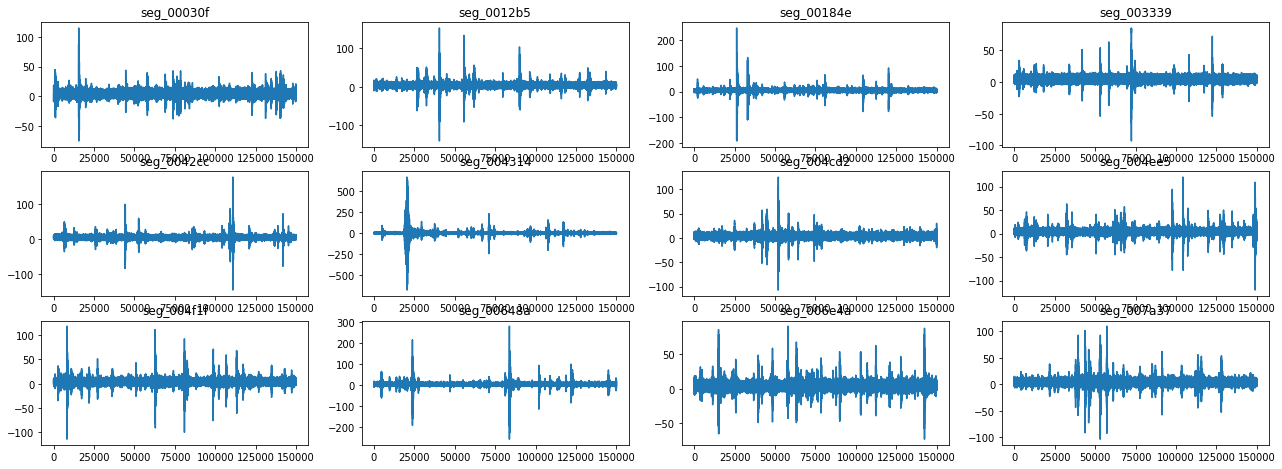

In [4]:
submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id')
X_test = pd.DataFrame(columns=X_tr.columns, dtype=np.float64, index=submission.index)
plt.figure(figsize=(22, 16))

for i, seg_id in enumerate(tqdm_notebook(X_test.index)):
    seg = pd.read_csv('../input/test/' + seg_id + '.csv')
    
    x = pd.Series(seg['acoustic_data'].values)
    X_test.loc[seg_id, 'mean'] = x.mean()
    X_test.loc[seg_id, 'std'] = x.std()
    X_test.loc[seg_id, 'max'] = x.max()
    X_test.loc[seg_id, 'min'] = x.min()
        
    X_test.loc[seg_id, 'mean_change_abs'] = np.mean(np.diff(x))
    X_test.loc[seg_id, 'mean_change_rate'] = np.mean(np.nonzero((np.diff(x) / x[:-1]))[0])
    X_test.loc[seg_id, 'abs_max'] = np.abs(x).max()
    X_test.loc[seg_id, 'abs_min'] = np.abs(x).min()
    
    X_test.loc[seg_id, 'std_first_50000'] = x[:50000].std()
    X_test.loc[seg_id, 'std_last_50000'] = x[-50000:].std()
    X_test.loc[seg_id, 'std_first_10000'] = x[:10000].std()
    X_test.loc[seg_id, 'std_last_10000'] = x[-10000:].std()
    
    X_test.loc[seg_id, 'avg_first_50000'] = x[:50000].mean()
    X_test.loc[seg_id, 'avg_last_50000'] = x[-50000:].mean()
    X_test.loc[seg_id, 'avg_first_10000'] = x[:10000].mean()
    X_test.loc[seg_id, 'avg_last_10000'] = x[-10000:].mean()
    
    X_test.loc[seg_id, 'min_first_50000'] = x[:50000].min()
    X_test.loc[seg_id, 'min_last_50000'] = x[-50000:].min()
    X_test.loc[seg_id, 'min_first_10000'] = x[:10000].min()
    X_test.loc[seg_id, 'min_last_10000'] = x[-10000:].min()
    
    X_test.loc[seg_id, 'max_first_50000'] = x[:50000].max()
    X_test.loc[seg_id, 'max_last_50000'] = x[-50000:].max()
    X_test.loc[seg_id, 'max_first_10000'] = x[:10000].max()
    X_test.loc[seg_id, 'max_last_10000'] = x[-10000:].max()
    
    X_test.loc[seg_id, 'max_to_min'] = x.max() / np.abs(x.min())
    X_test.loc[seg_id, 'max_to_min_diff'] = x.max() - np.abs(x.min())
    X_test.loc[seg_id, 'count_big'] = len(x[np.abs(x) > 500])
    X_test.loc[seg_id, 'sum'] = x.sum()
    
    X_test.loc[seg_id, 'mean_change_rate_first_50000'] = np.mean(np.nonzero((np.diff(x[:50000]) / x[:50000][:-1]))[0])
    X_test.loc[seg_id, 'mean_change_rate_last_50000'] = np.mean(np.nonzero((np.diff(x[-50000:]) / x[-50000:][:-1]))[0])
    X_test.loc[seg_id, 'mean_change_rate_first_10000'] = np.mean(np.nonzero((np.diff(x[:10000]) / x[:10000][:-1]))[0])
    X_test.loc[seg_id, 'mean_change_rate_last_10000'] = np.mean(np.nonzero((np.diff(x[-10000:]) / x[-10000:][:-1]))[0])
    
    X_test.loc[seg_id, 'q95'] = np.quantile(x,0.95)
    X_test.loc[seg_id, 'q99'] = np.quantile(x,0.99)
    X_test.loc[seg_id, 'q05'] = np.quantile(x,0.05)
    X_test.loc[seg_id, 'q01'] = np.quantile(x,0.01)
    
    X_test.loc[seg_id, 'abs_q95'] = np.quantile(np.abs(x), 0.95)
    X_test.loc[seg_id, 'abs_q99'] = np.quantile(np.abs(x), 0.99)
    X_test.loc[seg_id, 'abs_q05'] = np.quantile(np.abs(x), 0.05)
    X_test.loc[seg_id, 'abs_q01'] = np.quantile(np.abs(x), 0.01)
    
    X_test.loc[seg_id, 'trend'] = add_trend_feature(x)
    X_test.loc[seg_id, 'abs_trend'] = add_trend_feature(x, abs_values=True)
    X_test.loc[seg_id, 'abs_mean'] = np.abs(x).mean()
    X_test.loc[seg_id, 'abs_std'] = np.abs(x).std()
    
    X_test.loc[seg_id, 'mad'] = x.mad()
    X_test.loc[seg_id, 'kurt'] = x.kurtosis()
    X_test.loc[seg_id, 'skew'] = x.skew()
    X_test.loc[seg_id, 'med'] = x.median()
    
    X_test.loc[seg_id, 'Hilbert_mean'] = np.abs(hilbert(x)).mean()
    X_test.loc[seg_id, 'Hann_window_mean'] = (convolve(x, hann(150), mode='same') / sum(hann(150))).mean()
    X_test.loc[seg_id, 'classic_sta_lta1_mean'] = classic_sta_lta(x, 500, 10000).mean()
    X_test.loc[seg_id, 'classic_sta_lta2_mean'] = classic_sta_lta(x, 5000, 100000).mean()
    X_test.loc[seg_id, 'classic_sta_lta3_mean'] = classic_sta_lta(x, 3333, 6666).mean()
    X_test.loc[seg_id, 'classic_sta_lta4_mean'] = classic_sta_lta(x, 10000, 25000).mean()
    X_test.loc[seg_id, 'Moving_average_700_mean'] = x.rolling(window=700).mean().mean(skipna=True)
    X_test.loc[seg_id, 'Moving_average_1500_mean'] = x.rolling(window=1500).mean().mean(skipna=True)
    X_test.loc[seg_id, 'Moving_average_3000_mean'] = x.rolling(window=3000).mean().mean(skipna=True)
    X_test.loc[seg_id, 'Moving_average_6000_mean'] = x.rolling(window=6000).mean().mean(skipna=True)
    ewma = pd.Series.ewm
    X_test.loc[seg_id, 'exp_Moving_average_300_mean'] = (ewma(x, span=300).mean()).mean(skipna=True)
    X_test.loc[seg_id, 'exp_Moving_average_3000_mean'] = ewma(x, span=3000).mean().mean(skipna=True)
    X_test.loc[seg_id, 'exp_Moving_average_30000_mean'] = ewma(x, span=6000).mean().mean(skipna=True)
    no_of_std = 2
    X_test.loc[seg_id, 'MA_700MA_std_mean'] = x.rolling(window=700).std().mean()
    X_test.loc[seg_id,'MA_700MA_BB_high_mean'] = (X_test.loc[seg_id, 'Moving_average_700_mean'] + no_of_std * X_test.loc[seg_id, 'MA_700MA_std_mean']).mean()
    X_test.loc[seg_id,'MA_700MA_BB_low_mean'] = (X_test.loc[seg_id, 'Moving_average_700_mean'] - no_of_std * X_test.loc[seg_id, 'MA_700MA_std_mean']).mean()
    X_test.loc[seg_id, 'MA_400MA_std_mean'] = x.rolling(window=400).std().mean()
    X_test.loc[seg_id,'MA_400MA_BB_high_mean'] = (X_test.loc[seg_id, 'Moving_average_700_mean'] + no_of_std * X_test.loc[seg_id, 'MA_400MA_std_mean']).mean()
    X_test.loc[seg_id,'MA_400MA_BB_low_mean'] = (X_test.loc[seg_id, 'Moving_average_700_mean'] - no_of_std * X_test.loc[seg_id, 'MA_400MA_std_mean']).mean()
    X_test.loc[seg_id, 'MA_1000MA_std_mean'] = x.rolling(window=1000).std().mean()
    
    X_test.loc[seg_id, 'iqr'] = np.subtract(*np.percentile(x, [75, 25]))
    X_test.loc[seg_id, 'q999'] = np.quantile(x,0.999)
    X_test.loc[seg_id, 'q001'] = np.quantile(x,0.001)
    X_test.loc[seg_id, 'ave10'] = stats.trim_mean(x, 0.1)
    
    for windows in [10, 100, 1000]:
        x_roll_std = x.rolling(windows).std().dropna().values
        x_roll_mean = x.rolling(windows).mean().dropna().values
        
        X_test.loc[seg_id, 'ave_roll_std_' + str(windows)] = x_roll_std.mean()
        X_test.loc[seg_id, 'std_roll_std_' + str(windows)] = x_roll_std.std()
        X_test.loc[seg_id, 'max_roll_std_' + str(windows)] = x_roll_std.max()
        X_test.loc[seg_id, 'min_roll_std_' + str(windows)] = x_roll_std.min()
        X_test.loc[seg_id, 'q01_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.01)
        X_test.loc[seg_id, 'q05_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.05)
        X_test.loc[seg_id, 'q95_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.95)
        X_test.loc[seg_id, 'q99_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.99)
        X_test.loc[seg_id, 'av_change_abs_roll_std_' + str(windows)] = np.mean(np.diff(x_roll_std))
        X_test.loc[seg_id, 'av_change_rate_roll_std_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_std) / x_roll_std[:-1]))[0])
        X_test.loc[seg_id, 'abs_max_roll_std_' + str(windows)] = np.abs(x_roll_std).max()
        
        X_test.loc[seg_id, 'ave_roll_mean_' + str(windows)] = x_roll_mean.mean()
        X_test.loc[seg_id, 'std_roll_mean_' + str(windows)] = x_roll_mean.std()
        X_test.loc[seg_id, 'max_roll_mean_' + str(windows)] = x_roll_mean.max()
        X_test.loc[seg_id, 'min_roll_mean_' + str(windows)] = x_roll_mean.min()
        X_test.loc[seg_id, 'q01_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.01)
        X_test.loc[seg_id, 'q05_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.05)
        X_test.loc[seg_id, 'q95_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.95)
        X_test.loc[seg_id, 'q99_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.99)
        X_test.loc[seg_id, 'av_change_abs_roll_mean_' + str(windows)] = np.mean(np.diff(x_roll_mean))
        X_test.loc[seg_id, 'av_change_rate_roll_mean_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_mean) / x_roll_mean[:-1]))[0])
        X_test.loc[seg_id, 'abs_max_roll_mean_' + str(windows)] = np.abs(x_roll_mean).max()
    
    if i < 12:
        plt.subplot(6, 4, i + 1)
        plt.plot(seg['acoustic_data'])
        plt.title(seg_id)

In [5]:
def GPT1(data):
    return (-0.000008 +
            1.0*np.tanh(((((data["ave_roll_std_100"]) + ((((-1.0*((((data["q95_roll_mean_1000"]) + (((((data["sum"]) * 2.0)) * 2.0))))))) - (data["mean"]))))) * 2.0)) +
            1.0*np.tanh((-1.0*((((data["med"]) + (((data["mean_change_rate"]) + (((((data["exp_Moving_average_30000_mean"]) + (data["q05_roll_mean_100"]))) * 2.0))))))))) +
            1.0*np.tanh((((-1.0*((((data["med"]) * 2.0))))) - (((((((data["q05_roll_mean_100"]) * 2.0)) - ((-1.0*((data["q001"])))))) * 2.0)))) +
            1.0*np.tanh((((((((-1.0*((data["q01"])))) - (((data["ave_roll_mean_1000"]) + (((data["av_change_rate_roll_mean_1000"]) + (((data["Moving_average_6000_mean"]) * 2.0)))))))) * 2.0)) * 2.0)) +
            1.0*np.tanh(((((data["q01_roll_std_100"]) - (((data["exp_Moving_average_300_mean"]) * 2.0)))) + ((-1.0*((((data["med"]) * 2.0))))))) +
            1.0*np.tanh(((data["q05_roll_std_100"]) - (((data["ave_roll_mean_1000"]) + (((((((data["ave_roll_mean_100"]) * 2.0)) + (data["q99_roll_mean_1000"]))) + (data["exp_Moving_average_300_mean"]))))))) +
            1.0*np.tanh((((-1.0*((((data["av_change_rate_roll_mean_100"]) + (data["sum"])))))) - (((data["q95_roll_mean_1000"]) + (((data["med"]) + (data["exp_Moving_average_3000_mean"]))))))) +
            1.0*np.tanh(((((data["q05_roll_std_100"]) - (((data["q05_roll_mean_1000"]) + (((data["Moving_average_700_mean"]) + (data["q05_roll_mean_100"]))))))) - (data["Moving_average_6000_mean"]))) +
            1.0*np.tanh(((data["q99_roll_mean_1000"]) - (((data["med"]) + (((((((((data["q99_roll_mean_1000"]) * 2.0)) * 2.0)) + (((data["med"]) * 2.0)))) * 2.0)))))) +
            1.0*np.tanh(((((((-1.0) - (((data["mean"]) * 2.0)))) * 2.0)) * 2.0)) +
            1.0*np.tanh((((-1.0*((((((data["abs_q05"]) * 2.0)) - (data["MA_400MA_std_mean"])))))) - (((data["med"]) + (np.tanh((((data["med"]) * 2.0)))))))) +
            1.0*np.tanh((-1.0*((((((((data["abs_q05"]) * 2.0)) - (((data["q05_roll_std_1000"]) / 2.0)))) - (((((data["max_roll_mean_10"]) - (data["Moving_average_3000_mean"]))) * 2.0))))))) +
            1.0*np.tanh((-1.0*((((data["Moving_average_1500_mean"]) + (((data["Moving_average_3000_mean"]) + (((data["q05_roll_mean_100"]) + (data["max"])))))))))) +
            1.0*np.tanh((((-1.0*((((((((data["med"]) + (data["abs_max_roll_mean_1000"]))) * 2.0)) + (data["med"])))))) * 2.0)) +
            1.0*np.tanh(((data["max_roll_mean_100"]) - (((((((data["abs_q05"]) + (((data["abs_q05"]) * 2.0)))) * 2.0)) + (((data["abs_q05"]) * 2.0)))))) +
            1.0*np.tanh(((data["ave10"]) + ((((((-1.0*((((data["med"]) - (data["abs_max_roll_std_1000"])))))) * 2.0)) - (((data["abs_q05"]) * 2.0)))))) +
            1.0*np.tanh((((-1.0*((((data["ave_roll_mean_10"]) - (data["q99_roll_std_10"])))))) - (((data["abs_q05"]) - ((-1.0*((((data["abs_q05"]) - (data["q95_roll_std_10"])))))))))) +
            1.0*np.tanh((((((((-1.0*((((data["med"]) * 2.0))))) * 2.0)) - (((data["q99_roll_mean_1000"]) * 2.0)))) * 2.0)) +
            1.0*np.tanh(((data["classic_sta_lta1_mean"]) - (((data["abs_q05"]) + (((((data["abs_q05"]) - (data["max_last_10000"]))) * 2.0)))))) +
            1.0*np.tanh(((((3.0) + (((data["av_change_rate_roll_mean_1000"]) - (data["ave_roll_mean_1000"]))))) - (((((data["ave_roll_mean_100"]) - (data["ave_roll_std_10"]))) * 2.0)))) +
            1.0*np.tanh((-1.0*((((((data["abs_q05"]) + ((((data["abs_max_roll_mean_10"]) + ((((data["abs_q05"]) + (data["med"]))/2.0)))/2.0)))) * 2.0))))) +
            1.0*np.tanh(((((data["q01_roll_std_100"]) + ((((4.00706386566162109)) - (((((data["exp_Moving_average_300_mean"]) + (data["med"]))) * 2.0)))))) * 2.0)) +
            1.0*np.tanh(((((((data["abs_q05"]) * 2.0)) - (((((((data["abs_q05"]) + (data["abs_q05"]))) * 2.0)) * 2.0)))) - (data["abs_q05"]))) +
            1.0*np.tanh(((((((data["q05_roll_std_1000"]) + (((((((np.tanh((3.0))) - (data["Hann_window_mean"]))) * 2.0)) * 2.0)))) * 2.0)) * 2.0)) +
            1.0*np.tanh(((((((((data["q05_roll_mean_1000"]) * (((data["abs_q05"]) + (((data["abs_q05"]) - (data["Moving_average_6000_mean"]))))))) * 2.0)) * 2.0)) - (data["abs_q05"]))) +
            1.0*np.tanh(((((data["med"]) * (((((data["std_roll_mean_10"]) * 2.0)) * 2.0)))) - (((data["ave_roll_mean_100"]) * (((data["avg_first_50000"]) * (data["q95_roll_mean_100"]))))))) +
            1.0*np.tanh((((-1.0*((((data["iqr"]) * (((((data["abs_mean"]) / 2.0)) - (data["q05_roll_mean_100"])))))))) - (data["abs_q05"]))) +
            1.0*np.tanh((((((data["ave10"]) + (data["Moving_average_700_mean"]))) + (((data["Moving_average_700_mean"]) * (((data["ave10"]) * ((((-1.0*((data["Moving_average_700_mean"])))) * 2.0)))))))/2.0)) +
            1.0*np.tanh(((((((data["iqr"]) * (((((((data["med"]) * 2.0)) * 2.0)) + (data["med"]))))) - (data["Moving_average_6000_mean"]))) - (data["avg_last_10000"]))) +
            1.0*np.tanh(((data["iqr"]) - (((data["Moving_average_1500_mean"]) + (((np.tanh(((-1.0*((((data["av_change_rate_roll_std_100"]) * (data["med"])))))))) * 2.0)))))) +
            1.0*np.tanh(((((data["Moving_average_6000_mean"]) * 2.0)) * (((((data["std_last_50000"]) + (((data["abs_q05"]) * 2.0)))) - (data["ave_roll_mean_100"]))))) +
            1.0*np.tanh((((((((data["av_change_rate_roll_std_10"]) * (data["med"]))) - (((data["q01_roll_mean_1000"]) * (((data["avg_last_10000"]) * (data["q05_roll_mean_1000"]))))))) + (data["q01_roll_mean_1000"]))/2.0)) +
            1.0*np.tanh(((data["ave_roll_mean_10"]) + ((((data["Moving_average_1500_mean"]) + (((data["exp_Moving_average_300_mean"]) * (((((data["q05_roll_mean_1000"]) * ((-1.0*((data["exp_Moving_average_30000_mean"])))))) * 2.0)))))/2.0)))) +
            1.0*np.tanh((((((data["std_roll_std_100"]) + ((-1.0*(((-1.0*((data["q05_roll_mean_1000"]))))))))/2.0)) * (((((data["Moving_average_700_mean"]) / 2.0)) * ((-1.0*((data["Moving_average_700_mean"])))))))) +
            1.0*np.tanh(((((data["MA_700MA_BB_high_mean"]) + (data["std_last_10000"]))) * (((((data["med"]) + (data["abs_trend"]))) - (((data["Moving_average_6000_mean"]) * (data["av_change_rate_roll_mean_1000"]))))))) +
            1.0*np.tanh(((data["abs_q05"]) * (((data["av_change_rate_roll_mean_100"]) * (((data["MA_700MA_BB_low_mean"]) * 2.0)))))) +
            0.952325*np.tanh(((((data["max_last_50000"]) * (np.tanh((((data["av_change_rate_roll_mean_100"]) * (((((data["iqr"]) + (data["iqr"]))) + (data["iqr"]))))))))) * 2.0)) +
            1.0*np.tanh(((((data["q99_roll_mean_100"]) * ((-1.0*((data["avg_last_10000"])))))) * (((data["sum"]) - (data["q05_roll_std_10"]))))) +
            0.957405*np.tanh(np.tanh((np.tanh((np.tanh((np.tanh((np.tanh((np.tanh((((np.tanh((((data["sum"]) * 2.0)))) * 2.0)))))))))))))) +
            1.0*np.tanh(((data["max_roll_std_100"]) * ((((data["ave_roll_mean_1000"]) + ((((((data["std_roll_mean_100"]) + (((data["av_change_abs_roll_std_100"]) + (data["mad"]))))/2.0)) - (data["iqr"]))))/2.0)))) +
            1.0*np.tanh(((((data["std_roll_mean_1000"]) / 2.0)) - (((data["classic_sta_lta4_mean"]) * (((((-1.0*((data["med"])))) + (((data["q05_roll_std_100"]) * (data["abs_q05"]))))/2.0)))))) +
            1.0*np.tanh(((data["q05_roll_mean_100"]) * (((data["abs_max_roll_mean_1000"]) * (((data["abs_max_roll_mean_10"]) - (((data["q05_roll_mean_100"]) / 2.0)))))))) +
            0.885893*np.tanh((((((((data["mean_change_rate_last_10000"]) + (((((np.tanh((data["abs_q05"]))) / 2.0)) / 2.0)))) + (data["abs_q05"]))/2.0)) / 2.0)) +
            1.0*np.tanh(((data["q95_roll_mean_10"]) * ((((data["q05_roll_mean_10"]) + (((((((((data["MA_700MA_BB_low_mean"]) * (data["abs_q99"]))) + (data["abs_max_roll_mean_1000"]))) / 2.0)) * 2.0)))/2.0)))) +
            0.922626*np.tanh(((((((data["std_roll_std_100"]) * (((data["max"]) + (data["std_roll_mean_100"]))))) * (data["max_roll_std_100"]))) * (data["med"]))) +
            1.0*np.tanh(((((data["abs_q05"]) * (((data["abs_max_roll_std_100"]) * (((data["abs_max_roll_std_1000"]) * (data["av_change_rate_roll_std_100"]))))))) * (data["max_roll_std_100"]))) +
            0.999609*np.tanh(((np.tanh(((((((np.tanh((((data["abs_max_roll_mean_1000"]) / 2.0)))) - (((data["avg_first_10000"]) / 2.0)))) + (data["min_last_10000"]))/2.0)))) / 2.0)) +
            0.854631*np.tanh(((np.tanh((((data["q05_roll_mean_1000"]) / 2.0)))) * ((((((data["mean"]) + (((data["abs_max_roll_std_10"]) * (data["mean"]))))/2.0)) * (data["q95_roll_std_1000"]))))) +
            0.966784*np.tanh(((data["max_roll_mean_1000"]) * (((data["q95_roll_mean_1000"]) - (((data["max_roll_mean_1000"]) * (data["abs_min"]))))))) +
            1.0*np.tanh(((data["avg_first_10000"]) * (((data["max"]) * (((data["std_last_10000"]) + ((((((data["MA_400MA_BB_high_mean"]) + (data["max_roll_mean_1000"]))/2.0)) + (data["std_first_10000"]))))))))) +
            1.0*np.tanh((((((((data["abs_trend"]) + (data["q01_roll_std_1000"]))/2.0)) * (((((((data["abs_q05"]) / 2.0)) + (data["abs_q05"]))) / 2.0)))) / 2.0)) +
            1.0*np.tanh((((((((data["q99_roll_std_1000"]) - ((-1.0*((((data["min_roll_std_10"]) * 2.0))))))) + (data["std_roll_std_10"]))/2.0)) * (((data["mean_change_rate"]) * (data["std_roll_std_10"]))))) +
            1.0*np.tanh((((((((((((((data["q99_roll_mean_100"]) * (data["q001"]))) + (data["std_roll_std_10"]))/2.0)) / 2.0)) / 2.0)) / 2.0)) / 2.0)) +
            0.989058*np.tanh(((((((((data["min_first_10000"]) / 2.0)) / 2.0)) / 2.0)) * ((((data["count_big"]) + (np.tanh(((((-3.0) + (data["MA_700MA_BB_low_mean"]))/2.0)))))/2.0)))) +
            0.909340*np.tanh(((((data["max_last_10000"]) * (np.tanh((((np.tanh((data["abs_q01"]))) - (np.tanh((np.tanh((data["Moving_average_1500_mean"]))))))))))) / 2.0)) +
            0.804220*np.tanh(((((-1.0*((data["max_to_min_diff"])))) + (((((data["abs_min"]) / 2.0)) * (data["abs_min"]))))/2.0)) +
            1.0*np.tanh(((data["max_to_min_diff"]) * (((((((data["abs_q99"]) + (np.tanh((data["abs_q99"]))))/2.0)) + (data["abs_q99"]))/2.0)))) +
            1.0*np.tanh((-1.0*((((((((0.0) + (((data["std_first_50000"]) / 2.0)))/2.0)) + (data["abs_trend"]))/2.0))))) +
            1.0*np.tanh((((((((data["min_first_10000"]) / 2.0)) + ((((((data["max_roll_mean_10"]) - (data["std_roll_mean_100"]))) + (data["mean_change_abs"]))/2.0)))/2.0)) / 2.0)) +
            1.0*np.tanh(((data["q99_roll_mean_100"]) * ((-1.0*((((data["ave_roll_mean_1000"]) * ((((data["q05_roll_mean_10"]) + (data["q99_roll_mean_100"]))/2.0))))))))) +
            0.682689*np.tanh(((data["mean_change_rate_last_10000"]) * (((((((((data["min_last_50000"]) + (data["MA_400MA_BB_high_mean"]))/2.0)) * 2.0)) + (data["MA_400MA_BB_high_mean"]))/2.0)))) +
            0.962485*np.tanh(((((((((data["abs_q05"]) + (((data["max_last_10000"]) * (((data["abs_q05"]) + (data["std_roll_mean_1000"]))))))) / 2.0)) / 2.0)) / 2.0)) +
            1.0*np.tanh((((((data["min_last_10000"]) * (np.tanh((((data["iqr"]) / 2.0)))))) + (((data["abs_q01"]) * (np.tanh((data["abs_min"]))))))/2.0)) +
            0.833920*np.tanh(((data["abs_q01"]) / 2.0)) +
            1.0*np.tanh(((0.0) * (np.tanh((data["abs_q01"]))))) +
            0.923017*np.tanh(((data["q95_roll_mean_100"]) * (((((data["std_first_50000"]) - (np.tanh((((((data["abs_min"]) / 2.0)) * 2.0)))))) * (data["av_change_rate_roll_mean_100"]))))) +
            1.0*np.tanh((((((data["count_big"]) + (((data["mean_change_abs"]) + (np.tanh((np.tanh((data["avg_last_50000"]))))))))/2.0)) * (((data["min_first_10000"]) / 2.0)))) +
            1.0*np.tanh(((data["avg_first_50000"]) * ((-1.0*((((data["max_roll_mean_1000"]) * (((data["avg_first_50000"]) / 2.0))))))))) +
            0.782337*np.tanh(np.tanh((((((data["iqr"]) / 2.0)) * (((((data["exp_Moving_average_300_mean"]) / 2.0)) * (((data["iqr"]) + (data["avg_first_10000"]))))))))) +
            0.908558*np.tanh((((((np.tanh((np.tanh(((-1.0*((data["iqr"])))))))) + (((((data["min_roll_std_10"]) * (data["iqr"]))) / 2.0)))/2.0)) / 2.0)) +
            0.769832*np.tanh((((((data["min_roll_std_10"]) * ((-1.0*((((data["max_roll_std_10"]) / 2.0))))))) + (((data["mean_change_rate_last_10000"]) * ((-1.0*((data["max_roll_mean_10"])))))))/2.0)) +
            0.926925*np.tanh(((((np.tanh((((((data["kurt"]) / 2.0)) / 2.0)))) / 2.0)) / 2.0)) +
            1.0*np.tanh((((((((data["max_first_50000"]) + (data["q01_roll_mean_100"]))) + (0.0))/2.0)) * (((data["av_change_abs_roll_std_10"]) * (np.tanh((data["q99"]))))))) +
            0.982024*np.tanh((((((((((data["av_change_abs_roll_std_1000"]) / 2.0)) * (data["av_change_abs_roll_std_10"]))) + (np.tanh((np.tanh((np.tanh((data["std_roll_mean_100"]))))))))/2.0)) / 2.0)) +
            0.794060*np.tanh(np.tanh((0.0))) +
            0.995701*np.tanh(((data["abs_q01"]) * (((0.0) * (data["std_roll_mean_1000"]))))) +
            1.0*np.tanh(((((data["av_change_abs_roll_std_100"]) / 2.0)) * (((((data["av_change_abs_roll_std_100"]) / 2.0)) * ((((data["abs_q05"]) + (np.tanh((data["abs_min"]))))/2.0)))))) +
            0.784291*np.tanh(((data["Moving_average_6000_mean"]) * (((data["Moving_average_6000_mean"]) * (((data["q99_roll_mean_100"]) * (((data["av_change_rate_roll_mean_10"]) * ((((-1.0*((data["Hann_window_mean"])))) / 2.0)))))))))) +
            0.973427*np.tanh((((data["abs_q01"]) + (((np.tanh((data["iqr"]))) * ((-1.0*((((data["classic_sta_lta4_mean"]) / 2.0))))))))/2.0)) +
            0.870262*np.tanh(((data["iqr"]) * (((data["iqr"]) * (np.tanh(((((data["av_change_rate_roll_std_10"]) + (((data["iqr"]) * (data["abs_trend"]))))/2.0)))))))) +
            1.0*np.tanh(np.tanh(((((((np.tanh((data["q01_roll_mean_100"]))) + (0.0))/2.0)) * (np.tanh((data["q99_roll_mean_1000"]))))))) +
            0.668230*np.tanh(((data["av_change_abs_roll_mean_10"]) * (data["abs_max_roll_mean_1000"]))) +
            0.949199*np.tanh(((np.tanh((np.tanh((np.tanh((((data["std_last_50000"]) * (((((-1.0*((data["Moving_average_1500_mean"])))) + (data["med"]))/2.0)))))))))) / 2.0)) +
            1.0*np.tanh(((((data["max_to_min"]) * (np.tanh((((data["min_roll_mean_1000"]) * (((np.tanh((((data["abs_max_roll_std_100"]) * 2.0)))) * 2.0)))))))) / 2.0)) +
            0.945682*np.tanh((((-1.0*((data["max_roll_mean_1000"])))) * ((((data["classic_sta_lta1_mean"]) + (((data["q99_roll_std_10"]) * (data["classic_sta_lta1_mean"]))))/2.0)))) +
            1.0*np.tanh(((data["abs_q05"]) * (((((data["max_last_50000"]) * (data["std_last_50000"]))) * ((((data["std_last_50000"]) + (data["max"]))/2.0)))))) +
            0.999609*np.tanh(((np.tanh((data["max_last_10000"]))) * (((data["std_last_10000"]) - (np.tanh((data["max_last_10000"]))))))) +
            1.0*np.tanh(((((np.tanh((((data["min_last_10000"]) + (((data["q01"]) * (((data["q01_roll_mean_1000"]) + (data["abs_q99"]))))))))) / 2.0)) / 2.0)) +
            0.814771*np.tanh(np.tanh((np.tanh((((data["max_to_min_diff"]) * (data["std_last_50000"]))))))) +
            0.999218*np.tanh(((((((((data["min_first_50000"]) * (data["max_last_10000"]))) * (data["abs_max"]))) * (data["max_last_10000"]))) * (data["max_last_10000"]))) +
            0.921063*np.tanh(np.tanh((np.tanh((((data["q01_roll_mean_100"]) * (((data["MA_400MA_std_mean"]) * (data["Moving_average_6000_mean"]))))))))) +
            0.783118*np.tanh((((((-1.0*((data["ave_roll_std_10"])))) + (data["q99_roll_std_100"]))) / 2.0)) +
            0.977335*np.tanh(((data["skew"]) * (((data["skew"]) * (((data["min"]) * (((data["skew"]) * (data["std_roll_std_10"]))))))))) +
            0.557249*np.tanh((((np.tanh((((data["max_roll_std_10"]) - (np.tanh((data["abs_max_roll_std_100"]))))))) + (data["std_first_50000"]))/2.0)) +
            1.0*np.tanh(((((((((np.tanh((np.tanh((data["max_to_min_diff"]))))) + ((((data["min_last_50000"]) + (data["classic_sta_lta3_mean"]))/2.0)))/2.0)) + (np.tanh((data["abs_max_roll_mean_1000"]))))/2.0)) / 2.0)) +
            0.886284*np.tanh(data["abs_q01"]) +
            0.998046*np.tanh(data["abs_min"]) +
            0.847597*np.tanh(((((((data["classic_sta_lta3_mean"]) * (((data["med"]) * ((-1.0*((data["abs_max_roll_std_1000"])))))))) - (((((data["med"]) / 2.0)) / 2.0)))) / 2.0)) +
            0.818679*np.tanh(((np.tanh((((((np.tanh((data["Moving_average_6000_mean"]))) + (data["q01_roll_mean_100"]))) * (data["q01_roll_mean_100"]))))) / 2.0)) +
            0.620946*np.tanh(((((((((-1.0*((((1.0) / 2.0))))) / 2.0)) / 2.0)) + ((((data["MA_700MA_BB_high_mean"]) + (data["MA_700MA_BB_low_mean"]))/2.0)))/2.0)) +
            0.836655*np.tanh(((data["std_roll_std_1000"]) * (((data["max_last_10000"]) * (((data["min_roll_std_10"]) + (((data["av_change_abs_roll_std_100"]) + (((data["max_last_10000"]) / 2.0)))))))))) +
            1.0*np.tanh(((data["count_big"]) * (((((data["iqr"]) * (((((data["iqr"]) + (data["MA_400MA_BB_low_mean"]))) * 2.0)))) / 2.0)))) +
            0.937085*np.tanh(((((data["std_first_50000"]) * (((data["max_last_50000"]) * ((-1.0*((data["kurt"])))))))) * 2.0)) +
            1.0*np.tanh(((((data["max_last_50000"]) * ((((((data["classic_sta_lta1_mean"]) + (((data["std_roll_std_10"]) * (data["max_roll_mean_100"]))))/2.0)) / 2.0)))) * (data["std_first_10000"]))) +
            1.0*np.tanh(((np.tanh((((data["max_last_50000"]) * (np.tanh(((((((((data["std_roll_mean_1000"]) * 2.0)) * (data["max_last_50000"]))) + (data["std_roll_mean_1000"]))/2.0)))))))) / 2.0)) +
            0.908558*np.tanh((((((((data["min_roll_mean_100"]) + (data["std_roll_mean_10"]))) + ((((((data["min_roll_mean_100"]) + (data["std_roll_mean_10"]))/2.0)) / 2.0)))/2.0)) / 2.0)) +
            0.881985*np.tanh(((data["abs_q05"]) * (np.tanh((np.tanh((np.tanh((np.tanh((((data["abs_max_roll_std_100"]) * (data["MA_400MA_BB_low_mean"]))))))))))))) +
            0.575615*np.tanh((-1.0*(((-1.0*((((np.tanh((((0.0) / 2.0)))) / 2.0)))))))) +
            0.679172*np.tanh(((np.tanh((np.tanh((((((((data["Moving_average_3000_mean"]) - (data["iqr"]))) * 2.0)) - (data["iqr"]))))))) / 2.0)) +
            0.889019*np.tanh(((np.tanh(((((((data["q95_roll_std_10"]) + ((-1.0*((((data["avg_last_50000"]) - (data["abs_q05"])))))))/2.0)) / 2.0)))) / 2.0)) +
            0.999609*np.tanh(((((((np.tanh((((((data["av_change_abs_roll_std_100"]) + (data["med"]))) * 2.0)))) / 2.0)) * (data["av_change_abs_roll_std_1000"]))) / 2.0)) +
            0.998437*np.tanh(((((data["av_change_abs_roll_mean_10"]) * (((((((((data["av_change_abs_roll_mean_100"]) - (((-1.0) * 2.0)))) / 2.0)) / 2.0)) / 2.0)))) / 2.0)) +
            0.555295*np.tanh(((((data["mean_change_abs"]) * (data["std_last_10000"]))) / 2.0)) +
            0.736616*np.tanh((-1.0*((((data["abs_q05"]) * (np.tanh((np.tanh((np.tanh((((data["iqr"]) * ((((data["av_change_rate_roll_std_10"]) + (data["q95_roll_std_10"]))/2.0))))))))))))))) +
            0.954279*np.tanh(((((np.tanh(((((data["sum"]) + (((data["sum"]) * ((((data["classic_sta_lta2_mean"]) + (data["sum"]))/2.0)))))/2.0)))) / 2.0)) / 2.0)) +
            0.844471*np.tanh(((data["abs_max_roll_std_100"]) * (((data["ave_roll_mean_100"]) * ((((((data["q01_roll_mean_1000"]) / 2.0)) + (data["max_last_10000"]))/2.0)))))) +
            0.587730*np.tanh(((np.tanh((((data["avg_first_50000"]) - (np.tanh((data["std_roll_mean_1000"]))))))) * (data["std_roll_mean_1000"]))) +
            0.875342*np.tanh(((data["av_change_rate_roll_std_100"]) * (((((data["av_change_abs_roll_mean_1000"]) * (((((data["trend"]) / 2.0)) / 2.0)))) / 2.0)))) +
            0.859711*np.tanh((((np.tanh((((data["abs_max_roll_std_1000"]) - (data["max_roll_std_100"]))))) + ((((((data["trend"]) + (data["min_last_50000"]))/2.0)) / 2.0)))/2.0)) +
            0.999218*np.tanh((((((((((data["abs_q05"]) + (((data["q01_roll_std_100"]) * (data["abs_q05"]))))/2.0)) / 2.0)) / 2.0)) / 2.0)) +
            1.0*np.tanh((((-1.0*(((-1.0*(((-1.0*(((0.02310276590287685))))))))))) * (((data["Moving_average_6000_mean"]) - (data["min_first_10000"]))))) +
            0.867917*np.tanh((((((data["abs_q01"]) + (((np.tanh((((np.tanh((data["abs_max_roll_mean_100"]))) - (((data["av_change_rate_roll_std_100"]) + (0.0))))))) / 2.0)))/2.0)) / 2.0)) +
            0.847206*np.tanh(((0.0) * (0.0))) +
            0.998828*np.tanh(((((data["min_last_10000"]) * ((((np.tanh(((((data["av_change_rate_roll_mean_1000"]) + (data["min_last_10000"]))/2.0)))) + (np.tanh((data["q05_roll_mean_100"]))))/2.0)))) / 2.0)) +
            0.843689*np.tanh(((np.tanh((((data["av_change_rate_roll_mean_100"]) * (((0.0) - (np.tanh((np.tanh((np.tanh((np.tanh((data["iqr"]))))))))))))))) / 2.0)) +
            0.881594*np.tanh(np.tanh((np.tanh((((((data["min_roll_mean_1000"]) * (((0.0) - (np.tanh((data["av_change_rate_roll_std_10"]))))))) * (data["mean"]))))))) +
            1.0*np.tanh(((((((((np.tanh((((((data["mean_change_rate"]) - (((data["med"]) / 2.0)))) / 2.0)))) / 2.0)) * 2.0)) / 2.0)) / 2.0)) +
            0.581477*np.tanh(((np.tanh((np.tanh(((-1.0*((((np.tanh((np.tanh((data["mean_change_rate_last_10000"]))))) / 2.0))))))))) / 2.0)) +
            0.707698*np.tanh(np.tanh((np.tanh(((((((np.tanh((data["std_roll_mean_1000"]))) / 2.0)) + ((-1.0*((((data["trend"]) * (data["max_to_min_diff"])))))))/2.0)))))) +
            0.999218*np.tanh(((data["abs_q01"]) * ((((0.0) + (np.tanh((data["ave_roll_mean_10"]))))/2.0)))) +
            0.884330*np.tanh(((data["std_first_10000"]) * (((np.tanh((((data["av_change_rate_roll_mean_1000"]) - (data["Moving_average_3000_mean"]))))) / 2.0)))) +
            0.999609*np.tanh(0.0) +
            1.0*np.tanh(data["abs_q01"]) +
            0.787808*np.tanh(((data["min_last_10000"]) * (((((((((((data["std_first_10000"]) * (((((data["std_first_10000"]) / 2.0)) / 2.0)))) / 2.0)) / 2.0)) / 2.0)) / 2.0)))) +
            0.994529*np.tanh(((((((((data["abs_min"]) * (0.0))) / 2.0)) / 2.0)) / 2.0)) +
            0.850332*np.tanh(((((data["Moving_average_1500_mean"]) * (((data["Moving_average_1500_mean"]) * (((((((((data["abs_min"]) + (data["std_first_10000"]))/2.0)) + (data["std_first_10000"]))/2.0)) / 2.0)))))) / 2.0)) +
            0.699101*np.tanh(np.tanh((((((data["max_first_10000"]) * (((data["abs_q05"]) - (np.tanh(((((data["max_first_10000"]) + (data["Moving_average_6000_mean"]))/2.0)))))))) / 2.0)))) +
            0.996874*np.tanh((((((((((((-1.0*((data["avg_first_10000"])))) / 2.0)) / 2.0)) / 2.0)) / 2.0)) / 2.0)) +
            0.314576*np.tanh(((np.tanh((((((np.tanh((((data["MA_400MA_BB_low_mean"]) / 2.0)))) / 2.0)) / 2.0)))) / 2.0)) +
            0.731536*np.tanh(((data["mean_change_rate_first_50000"]) * (((((((data["mean_change_rate_first_50000"]) * (((data["max_roll_mean_10"]) * (data["av_change_abs_roll_std_10"]))))) / 2.0)) * (data["av_change_abs_roll_std_10"]))))) +
            0.998437*np.tanh(((((((((data["min_roll_mean_10"]) / 2.0)) / 2.0)) / 2.0)) / 2.0)) +
            0.661977*np.tanh((((((0.0) + (((((np.tanh((data["avg_first_50000"]))) / 2.0)) / 2.0)))/2.0)) / 2.0)) +
            0.932005*np.tanh(np.tanh((((data["Moving_average_1500_mean"]) - (data["ave10"]))))) +
            0.753810*np.tanh((((((((-1.0*(((((((-1.0*((((data["av_change_abs_roll_mean_1000"]) / 2.0))))) / 2.0)) / 2.0))))) / 2.0)) / 2.0)) / 2.0)) +
            0.998046*np.tanh(((np.tanh((((data["classic_sta_lta2_mean"]) * (np.tanh((((data["av_change_rate_roll_mean_100"]) * (np.tanh((data["min_first_50000"]))))))))))) / 2.0)) +
            0.996092*np.tanh(((data["Moving_average_1500_mean"]) - (data["ave_roll_mean_100"]))) +
            0.423603*np.tanh(data["abs_min"]) +
            0.998828*np.tanh(np.tanh((np.tanh((((data["classic_sta_lta3_mean"]) * ((-1.0*((((data["abs_max_roll_mean_1000"]) * (((((data["abs_max_roll_mean_1000"]) * (data["std_roll_mean_1000"]))) * 2.0))))))))))))) +
            0.647909*np.tanh((-1.0*((((np.tanh((np.tanh(((((np.tanh((data["abs_trend"]))) + (data["count_big"]))/2.0)))))) / 2.0))))) +
            0.801485*np.tanh(data["abs_q01"]) +
            0.999609*np.tanh(((((((((((data["mean_change_rate_last_50000"]) / 2.0)) / 2.0)) * (((data["av_change_abs_roll_std_1000"]) - (((data["Moving_average_6000_mean"]) / 2.0)))))) / 2.0)) / 2.0)) +
            0.999218*np.tanh(data["abs_q01"]) +
            0.998828*np.tanh(((np.tanh((((data["abs_max_roll_std_10"]) * (np.tanh((((data["abs_max_roll_std_10"]) * (np.tanh((data["med"]))))))))))) / 2.0)) +
            0.939039*np.tanh(((np.tanh((((((data["av_change_abs_roll_std_10"]) * (((data["kurt"]) * (data["kurt"]))))) * (((data["kurt"]) * (data["kurt"]))))))) / 2.0)) +
            0.546307*np.tanh((((-1.0*(((((((((data["av_change_abs_roll_mean_1000"]) / 2.0)) + (data["av_change_abs_roll_std_10"]))/2.0)) * (data["av_change_abs_roll_std_1000"])))))) / 2.0)) +
            0.998828*np.tanh((((data["abs_min"]) + ((-1.0*((((((((data["abs_q01"]) / 2.0)) / 2.0)) / 2.0))))))/2.0)) +
            1.0*np.tanh((((((-1.0*(((((((data["av_change_abs_roll_std_100"]) / 2.0)) + (((np.tanh((data["med"]))) / 2.0)))/2.0))))) / 2.0)) / 2.0)) +
            0.998437*np.tanh(0.0) +
            0.785854*np.tanh(((np.tanh((((np.tanh(((-1.0*((((data["mean_change_abs"]) * (data["avg_first_10000"])))))))) / 2.0)))) / 2.0)) +
            0.705354*np.tanh(np.tanh((((data["exp_Moving_average_300_mean"]) * (np.tanh((((data["exp_Moving_average_300_mean"]) * (np.tanh((((data["abs_max_roll_std_10"]) + ((-1.0*((data["max_roll_std_100"])))))))))))))))) +
            0.781946*np.tanh(data["abs_min"]) +
            0.921454*np.tanh(((((data["av_change_abs_roll_mean_100"]) / 2.0)) * ((((((((((data["av_change_abs_roll_mean_100"]) / 2.0)) + (data["abs_q01"]))/2.0)) / 2.0)) / 2.0)))) +
            1.0*np.tanh((((-1.0*((((np.tanh((np.tanh((((data["abs_q05"]) / 2.0)))))) / 2.0))))) * ((-1.0*((data["std_last_10000"])))))) +
            0.731145*np.tanh(((((data["std_last_50000"]) * ((-1.0*((((((data["max_to_min_diff"]) * 2.0)) * (((np.tanh((np.tanh((data["Moving_average_6000_mean"]))))) / 2.0))))))))) / 2.0)) +
            0.999609*np.tanh(((((((data["av_change_abs_roll_std_10"]) * (data["min_last_50000"]))) * (data["min_roll_std_100"]))) * ((-1.0*((np.tanh((data["min_first_50000"])))))))) +
            0.668621*np.tanh((((-1.0*((data["max_first_10000"])))) * ((((data["min_last_10000"]) + (np.tanh((((data["av_change_rate_roll_std_1000"]) * (data["min_last_10000"]))))))/2.0)))) +
            0.932786*np.tanh((((-1.0*(((((((((((0.0) / 2.0)) / 2.0)) / 2.0)) + ((((data["abs_min"]) + (np.tanh((data["max_first_50000"]))))/2.0)))/2.0))))) / 2.0)) +
            0.728019*np.tanh(((np.tanh((((((data["MA_700MA_BB_low_mean"]) * (data["std_first_50000"]))) * (data["abs_trend"]))))) / 2.0)) +
            0.828058*np.tanh(((data["min_first_10000"]) * ((((((np.tanh((((data["max_last_50000"]) / 2.0)))) + (data["max_first_50000"]))/2.0)) / 2.0)))) +
            0.923017*np.tanh(data["abs_min"]) +
            0.999609*np.tanh(((data["q05_roll_std_1000"]) * (((((data["abs_q01"]) + (((data["Hann_window_mean"]) - (data["Moving_average_6000_mean"]))))) + (((data["Hann_window_mean"]) - (data["Moving_average_6000_mean"]))))))) +
            0.917155*np.tanh(np.tanh((((((((((np.tanh((data["std_roll_mean_1000"]))) / 2.0)) / 2.0)) / 2.0)) / 2.0)))) +
            1.0*np.tanh(0.0) +
            0.630715*np.tanh(((((np.tanh((np.tanh((data["std_first_10000"]))))) / 2.0)) / 2.0)) +
            0.501368*np.tanh(data["abs_q01"]) +
            0.423603*np.tanh((-1.0*((((data["abs_q01"]) + (((data["ave_roll_mean_1000"]) - (data["Moving_average_1500_mean"])))))))) +
            0.722157*np.tanh(np.tanh((((np.tanh((np.tanh((np.tanh((((data["min_last_10000"]) * (data["abs_max_roll_mean_10"]))))))))) / 2.0)))) +
            0.424775*np.tanh(((((((np.tanh((((data["std_roll_mean_10"]) * (((data["max_roll_std_100"]) - (data["Moving_average_700_mean"]))))))) / 2.0)) / 2.0)) * 2.0)) +
            0.999609*np.tanh(((((np.tanh((((data["mean_change_abs"]) * ((-1.0*((np.tanh((data["count_big"])))))))))) / 2.0)) / 2.0)) +
            0.812427*np.tanh((((((((-1.0*((((((np.tanh((np.tanh((data["abs_q95"]))))) * 2.0)) / 2.0))))) / 2.0)) / 2.0)) / 2.0)) +
            0.540055*np.tanh(data["abs_min"]) +
            0.999609*np.tanh(data["abs_q01"]) +
            0.998046*np.tanh(data["abs_min"]) +
            0.998437*np.tanh(data["abs_min"]) +
            1.0*np.tanh(((data["av_change_abs_roll_mean_10"]) * ((((((((((data["Moving_average_6000_mean"]) + (((((data["av_change_abs_roll_mean_10"]) / 2.0)) / 2.0)))/2.0)) / 2.0)) / 2.0)) / 2.0)))) +
            0.738179*np.tanh(0.0) +
            0.790934*np.tanh(0.0) +
            0.930442*np.tanh(((((data["min_roll_std_10"]) * (((((np.tanh((np.tanh((data["av_change_rate_roll_std_10"]))))) / 2.0)) / 2.0)))) / 2.0)) +
            0.980852*np.tanh(data["abs_min"]) +
            0.999609*np.tanh(((((((((((((data["abs_min"]) - (((data["Hann_window_mean"]) - (data["exp_Moving_average_300_mean"]))))) * 2.0)) * 2.0)) - (0.0))) * 2.0)) * 2.0)) +
            0.991012*np.tanh(((data["Moving_average_1500_mean"]) - (data["Hann_window_mean"]))) +
            0.855021*np.tanh(0.0) +
            0.997655*np.tanh(((0.0) / 2.0)) +
            0.980852*np.tanh(0.0) +
            0.991794*np.tanh(((data["exp_Moving_average_3000_mean"]) - (data["exp_Moving_average_30000_mean"]))) +
            1.0*np.tanh(((((((data["av_change_abs_roll_mean_100"]) / 2.0)) * (((((((np.tanh((((data["max_last_10000"]) * 2.0)))) / 2.0)) / 2.0)) / 2.0)))) / 2.0)) +
            0.999609*np.tanh(((data["sum"]) * (((data["sum"]) * (((data["min_last_10000"]) * (np.tanh(((((0.0) + (data["std_last_50000"]))/2.0)))))))))) +
            1.0*np.tanh((((-1.0*((data["min_last_10000"])))) * (((((((((np.tanh((data["abs_q05"]))) * ((-1.0*((data["min_last_10000"])))))) / 2.0)) / 2.0)) / 2.0)))) +
            0.723329*np.tanh(np.tanh((np.tanh((((((((np.tanh((((data["Moving_average_1500_mean"]) * (data["Moving_average_1500_mean"]))))) / 2.0)) / 2.0)) / 2.0)))))) +
            0.607659*np.tanh((((((((((data["min_roll_mean_10"]) / 2.0)) + (((np.tanh((((data["q05_roll_std_10"]) - (3.0))))) / 2.0)))/2.0)) / 2.0)) / 2.0)) +
            0.920281*np.tanh(np.tanh((((data["std_last_10000"]) * (((((((((data["Hilbert_mean"]) / 2.0)) * (data["max_last_10000"]))) / 2.0)) / 2.0)))))) +
            0.843689*np.tanh(((((((((data["std_last_50000"]) * (np.tanh((((((data["mean_change_rate"]) - (((data["MA_1000MA_std_mean"]) * 2.0)))) * 2.0)))))) / 2.0)) / 2.0)) / 2.0)) +
            0.623290*np.tanh((-1.0*((((((np.tanh((((data["min_roll_mean_10"]) * (data["min_roll_std_1000"]))))) / 2.0)) / 2.0))))) +
            1.0*np.tanh(data["abs_q01"]) +
            0.836655*np.tanh((((((-1.0*((((data["abs_q01"]) - (((np.tanh((data["min_last_50000"]))) / 2.0))))))) / 2.0)) / 2.0)) +
            0.695584*np.tanh(((((((((-1.0*((np.tanh((((data["min_roll_mean_1000"]) * 2.0))))))) / 2.0)) + (((np.tanh((data["classic_sta_lta3_mean"]))) / 2.0)))/2.0)) / 2.0)) +
            0.893708*np.tanh((((((((((((((-1.0) + (((data["abs_min"]) * 2.0)))/2.0)) / 2.0)) / 2.0)) / 2.0)) / 2.0)) / 2.0)) +
            0.998828*np.tanh(((data["min_last_10000"]) * ((((0.0) + (((((-1.0*((0.0)))) + (((data["ave_roll_mean_100"]) + ((-1.0*((data["sum"])))))))/2.0)))/2.0)))) +
            0.845643*np.tanh(((((((data["q01_roll_std_100"]) - (data["q01_roll_std_1000"]))) * ((-1.0*((np.tanh(((((data["med"]) + (0.0))/2.0))))))))) / 2.0)) +
            0.893708*np.tanh(np.tanh((((((data["max_last_10000"]) / 2.0)) * (((((((data["std_last_50000"]) / 2.0)) - (data["q99_roll_mean_100"]))) / 2.0)))))) +
            0.998046*np.tanh(((((((data["max_roll_mean_10"]) - (data["max_roll_std_100"]))) * (((data["std_last_50000"]) / 2.0)))) / 2.0)) +
            1.0*np.tanh(np.tanh((((((np.tanh((((data["med"]) * (data["max_roll_mean_100"]))))) / 2.0)) / 2.0)))) +
            0.770223*np.tanh(((((((np.tanh((data["max_roll_mean_1000"]))) / 2.0)) / 2.0)) / 2.0)) +
            0.999218*np.tanh(((np.tanh((((data["med"]) / 2.0)))) * (((((((data["kurt"]) / 2.0)) / 2.0)) / 2.0)))) +
            0.771004*np.tanh(((data["Moving_average_1500_mean"]) * (((data["std_first_10000"]) * (np.tanh((np.tanh((((data["min_roll_mean_1000"]) + (data["std_roll_mean_100"]))))))))))) +
            0.856585*np.tanh(0.0) +
            0.484173*np.tanh(((((np.tanh((((((((((data["Moving_average_700_mean"]) - (data["ave_roll_mean_100"]))) * 2.0)) * 2.0)) * 2.0)))) * 2.0)) * 2.0)) +
            0.858148*np.tanh(((((((((((data["min_last_10000"]) / 2.0)) / 2.0)) / 2.0)) / 2.0)) / 2.0)) +
            0.999218*np.tanh(((((((data["std_first_10000"]) * (data["ave_roll_mean_1000"]))) * (((data["std_first_10000"]) + (data["min_first_10000"]))))) / 2.0)) +
            0.996092*np.tanh(((((data["exp_Moving_average_300_mean"]) - (data["exp_Moving_average_30000_mean"]))) * (((data["q99_roll_mean_100"]) / 2.0)))) +
            0.899961*np.tanh(data["abs_q01"]) +
            0.554513*np.tanh(((((((data["q999"]) + ((-1.0*((data["std_roll_mean_10"])))))/2.0)) + (0.0))/2.0)) +
            0.878859*np.tanh((((((((((np.tanh((np.tanh((((data["mean"]) * (data["ave10"]))))))) + ((-1.0*((data["skew"])))))/2.0)) / 2.0)) / 2.0)) / 2.0)) +
            0.0*np.tanh(data["abs_min"]) +
            0.999218*np.tanh((((((-1.0*((np.tanh((((data["abs_max_roll_std_100"]) * (np.tanh((((((data["avg_first_50000"]) * 2.0)) * 2.0))))))))))) / 2.0)) / 2.0)) +
            1.0*np.tanh(((((((((data["abs_q05"]) * (data["max_last_10000"]))) * (data["max_last_10000"]))) * (np.tanh((((data["abs_max"]) * 2.0)))))) / 2.0)) +
            0.998437*np.tanh(((((data["av_change_abs_roll_std_10"]) * (np.tanh(((((-1.0*((((data["q99_roll_std_100"]) * (((data["med"]) * 2.0))))))) / 2.0)))))) / 2.0)) +
            0.471278*np.tanh((-1.0*((((data["min_roll_std_10"]) * (((data["min_roll_std_10"]) * (((((((((data["count_big"]) / 2.0)) / 2.0)) / 2.0)) / 2.0))))))))) +
            0.878859*np.tanh(((np.tanh((((data["abs_q05"]) * ((((((((data["min_roll_std_100"]) + ((((data["min_roll_std_100"]) + (data["mean_change_abs"]))/2.0)))/2.0)) / 2.0)) / 2.0)))))) / 2.0)) +
            0.556467*np.tanh(((np.tanh((((((np.tanh((data["min_last_10000"]))) / 2.0)) / 2.0)))) / 2.0)) +
            0.457210*np.tanh(((np.tanh((((((((data["av_change_abs_roll_mean_100"]) * (data["av_change_abs_roll_mean_100"]))) * (data["q99_roll_mean_10"]))) / 2.0)))) / 2.0)) +
            0.677608*np.tanh(data["abs_q01"]) +
            0.824541*np.tanh(np.tanh((((np.tanh((((data["q99_roll_std_10"]) * (((data["av_change_abs_roll_mean_1000"]) * (data["min_roll_mean_10"]))))))) / 2.0)))) +
            0.999609*np.tanh(0.0) +
            0.865572*np.tanh(np.tanh((((((((data["max_roll_std_10"]) * (((((np.tanh(((((data["q001"]) + (data["abs_max_roll_mean_10"]))/2.0)))) / 2.0)) / 2.0)))) / 2.0)) / 2.0)))) +
            0.563111*np.tanh(((((((np.tanh((np.tanh((((data["av_change_abs_roll_mean_100"]) / 2.0)))))) / 2.0)) / 2.0)) / 2.0)) +
            0.816725*np.tanh(np.tanh((((((data["classic_sta_lta4_mean"]) * (((np.tanh((data["min_last_10000"]))) / 2.0)))) / 2.0)))) +
            0.0*np.tanh(((((np.tanh((((np.tanh((data["std_roll_mean_10"]))) / 2.0)))) / 2.0)) / 2.0)) +
            0.767097*np.tanh(((((((np.tanh((((np.tanh((((data["q95_roll_std_100"]) - (data["abs_min"]))))) - (data["q95"]))))) / 2.0)) / 2.0)) / 2.0)) +
            0.719031*np.tanh(((np.tanh((((data["max_to_min"]) * (((data["abs_q99"]) * ((((data["max_first_50000"]) + ((((data["abs_q99"]) + (data["abs_q99"]))/2.0)))/2.0)))))))) / 2.0)) +
            0.617429*np.tanh(((np.tanh((((np.tanh(((((((np.tanh((data["max_roll_mean_1000"]))) / 2.0)) + (data["abs_max_roll_std_1000"]))/2.0)))) / 2.0)))) / 2.0)) +
            0.997265*np.tanh(((np.tanh((((((((((data["abs_q05"]) / 2.0)) / 2.0)) / 2.0)) / 2.0)))) / 2.0)) +
            0.999609*np.tanh(((np.tanh((((data["av_change_rate_roll_mean_10"]) * (((((data["med"]) - (data["Moving_average_3000_mean"]))) / 2.0)))))) / 2.0)) +
            0.859320*np.tanh(((np.tanh((((data["max_roll_mean_10"]) * (np.tanh((((data["max_first_50000"]) * (data["std_roll_mean_1000"]))))))))) * (data["ave_roll_mean_10"]))) +
            0.297382*np.tanh(((np.tanh((np.tanh((np.tanh(((((((-1.0*((((((data["abs_q01"]) / 2.0)) + (data["q99"])))))) / 2.0)) / 2.0)))))))) / 2.0)) +
            0.467761*np.tanh(((((data["max_to_min_diff"]) * (((np.tanh((np.tanh((((data["max_last_10000"]) * (np.tanh((data["av_change_abs_roll_mean_1000"]))))))))) * (data["max_last_10000"]))))) / 2.0)) +
            0.999218*np.tanh((0.0)) +
            0.999218*np.tanh(((((np.tanh(((-1.0*((((((data["q99_roll_std_10"]) * (data["avg_first_50000"]))) * (data["classic_sta_lta1_mean"])))))))) / 2.0)) / 2.0)) +
            0.892927*np.tanh(((np.tanh((np.tanh(((((data["abs_max_roll_mean_100"]) + ((((-1.0*((((data["q99_roll_std_10"]) - (data["q999"])))))) * 2.0)))/2.0)))))) / 2.0)) +
            0.763579*np.tanh((((((-1.0*((((np.tanh((data["q99_roll_std_1000"]))) / 2.0))))) / 2.0)) / 2.0)) +
            0.999218*np.tanh(((((((np.tanh((data["abs_q01"]))) * 2.0)) * (np.tanh((data["abs_q01"]))))) / 2.0)) +
            0.739351*np.tanh(data["abs_q01"]) +
            0.867136*np.tanh(((((data["std"]) + ((-1.0*((data["std_roll_std_100"])))))) / 2.0)) +
            0.725674*np.tanh(((np.tanh((np.tanh((((np.tanh((data["exp_Moving_average_30000_mean"]))) * (((data["q01_roll_mean_100"]) + (((data["abs_max_roll_std_100"]) * (data["count_big"]))))))))))) / 2.0)) +
            0.996874*np.tanh(((((((np.tanh((((data["q01_roll_std_10"]) * ((-1.0*((data["q01_roll_std_10"])))))))) / 2.0)) / 2.0)) / 2.0)) +
            1.0*np.tanh(data["abs_q01"]))

def GPT2(data):
    return (-0.000001 +
            1.0*np.tanh(((((-1.0) * 2.0)) + ((((((-1.0*((((((data["q95_roll_mean_10"]) * 2.0)) * 2.0))))) * 2.0)) * 2.0)))) +
            1.0*np.tanh((((-1.0*((((data["q05_roll_std_100"]) * 2.0))))) - (((((((data["q05_roll_std_10"]) * 2.0)) * 2.0)) + (((((data["iqr"]) * 2.0)) * 2.0)))))) +
            1.0*np.tanh((((-1.0*((((np.tanh((data["sum"]))) + (((((data["q95_roll_std_10"]) + (data["abs_std"]))) + (((data["q01_roll_std_100"]) * 2.0))))))))) * 2.0)) +
            1.0*np.tanh((((((((((-1.0*((data["med"])))) - (data["q01_roll_std_10"]))) - (data["q95_roll_std_1000"]))) * 2.0)) - (((data["q05_roll_std_100"]) * 2.0)))) +
            1.0*np.tanh((((((-1.0*((data["q01_roll_std_1000"])))) + ((-1.0*((((((data["MA_700MA_BB_high_mean"]) * 2.0)) * 2.0))))))) * 2.0)) +
            1.0*np.tanh(((0.0) - (((((data["q01_roll_std_100"]) * 2.0)) + (((((data["med"]) * 2.0)) + (((data["q05_roll_std_100"]) * 2.0)))))))) +
            1.0*np.tanh((((((((-1.0*((data["q95_roll_mean_10"])))) - ((((((data["sum"]) + (data["av_change_rate_roll_std_100"]))/2.0)) / 2.0)))) * 2.0)) - (data["q01_roll_std_100"]))) +
            1.0*np.tanh((((((((-1.0*((((data["ave_roll_mean_100"]) + (data["q05_roll_std_10"])))))) * 2.0)) - ((((data["q05_roll_std_1000"]) + (data["av_change_rate_roll_mean_1000"]))/2.0)))) * 2.0)) +
            1.0*np.tanh(((((data["abs_q05"]) - (((((((((((data["MA_400MA_BB_high_mean"]) * 2.0)) * 2.0)) - (data["abs_q05"]))) + (data["q05_roll_std_10"]))) * 2.0)))) * 2.0)) +
            1.0*np.tanh((-1.0*((((((data["q05_roll_std_100"]) + (((data["q05_roll_std_100"]) + (data["med"]))))) + (((data["q95_roll_mean_1000"]) * (data["ave_roll_mean_100"])))))))) +
            1.0*np.tanh((((-1.0*((data["iqr"])))) - (((data["MA_700MA_BB_high_mean"]) + (((data["q95_roll_mean_100"]) * 2.0)))))) +
            1.0*np.tanh(((((((data["q05_roll_mean_10"]) - (data["min_roll_std_100"]))) - (((data["ave_roll_std_10"]) / 2.0)))) + (((((data["q05_roll_mean_10"]) * 2.0)) * 2.0)))) +
            1.0*np.tanh((((((-1.0*((((data["exp_Moving_average_300_mean"]) + (data["iqr"])))))) * 2.0)) - (((((data["Moving_average_3000_mean"]) + (((data["std_roll_std_10"]) * 2.0)))) * 2.0)))) +
            1.0*np.tanh((((((-1.0*((data["abs_max"])))) + (data["q01_roll_mean_10"]))) - ((((data["med"]) + (data["min_roll_std_1000"]))/2.0)))) +
            1.0*np.tanh(((data["q01_roll_mean_10"]) + ((((((((-1.0*((data["q05_roll_mean_1000"])))) * (data["q05_roll_mean_100"]))) + (data["q01_roll_mean_10"]))) - ((-1.0*((data["min_roll_mean_10"])))))))) +
            1.0*np.tanh(((((((((data["min_roll_mean_10"]) + (((((data["abs_q05"]) + (data["MA_700MA_BB_low_mean"]))) / 2.0)))) - (data["abs_max_roll_std_100"]))) * 2.0)) / 2.0)) +
            1.0*np.tanh((((((((data["av_change_rate_roll_mean_100"]) + ((-1.0*((((data["exp_Moving_average_300_mean"]) * 2.0))))))/2.0)) + (data["min_roll_mean_10"]))) * 2.0)) +
            1.0*np.tanh(((((data["min_roll_mean_10"]) + ((-1.0*((((data["iqr"]) * (((data["abs_q05"]) * 2.0))))))))) + (np.tanh((data["av_change_rate_roll_std_100"]))))) +
            1.0*np.tanh(((((((((data["Hann_window_mean"]) * (data["q05_roll_std_1000"]))) * 2.0)) + (data["abs_q05"]))) + (data["MA_400MA_BB_low_mean"]))) +
            1.0*np.tanh((((((((data["q001"]) / 2.0)) / 2.0)) + (((((data["q001"]) + (((data["Hilbert_mean"]) * (data["exp_Moving_average_300_mean"]))))) * (data["abs_q05"]))))/2.0)) +
            1.0*np.tanh(((((((data["exp_Moving_average_300_mean"]) * (((data["MA_400MA_BB_high_mean"]) * 2.0)))) * (data["q05_roll_mean_10"]))) - (data["q999"]))) +
            1.0*np.tanh((((data["q01_roll_mean_10"]) + (data["min_first_10000"]))/2.0)) +
            1.0*np.tanh(((((data["abs_trend"]) - (data["abs_q95"]))) * (data["abs_q05"]))) +
            1.0*np.tanh(((data["max_roll_mean_10"]) * (((data["q05_roll_mean_10"]) + (data["min_roll_mean_10"]))))) +
            1.0*np.tanh(((((data["min_roll_mean_1000"]) * (((data["max"]) - (data["min_roll_mean_1000"]))))) * 2.0)) +
            1.0*np.tanh((((data["av_change_abs_roll_std_100"]) + ((((((data["av_change_rate_roll_mean_1000"]) + (data["min_roll_mean_10"]))/2.0)) - (data["std_first_10000"]))))/2.0)) +
            1.0*np.tanh(((data["Moving_average_3000_mean"]) * (((((data["std_first_10000"]) * (data["MA_700MA_BB_low_mean"]))) * 2.0)))) +
            1.0*np.tanh(((data["q05_roll_std_1000"]) * ((((data["q01_roll_mean_100"]) + (((data["q01_roll_std_10"]) + (data["q01_roll_mean_100"]))))/2.0)))) +
            1.0*np.tanh(data["min_roll_mean_1000"]) +
            1.0*np.tanh(((((data["min"]) + (((((data["min"]) / 2.0)) * 2.0)))) * (data["abs_max"]))) +
            1.0*np.tanh(((((data["abs_max_roll_mean_100"]) * (((data["q05"]) + (((data["min_last_10000"]) * (data["av_change_rate_roll_std_100"]))))))) * (data["abs_max_roll_mean_100"]))) +
            1.0*np.tanh(((data["MA_400MA_std_mean"]) * (((((((data["av_change_rate_roll_std_1000"]) * (((data["Moving_average_3000_mean"]) - (data["min_first_10000"]))))) * 2.0)) * 2.0)))) +
            1.0*np.tanh(((data["abs_q05"]) * (((data["mean_change_rate"]) - (((data["MA_1000MA_std_mean"]) + ((((data["std_roll_std_1000"]) + ((((data["q99_roll_std_100"]) + (data["std_roll_mean_10"]))/2.0)))/2.0)))))))) +
            1.0*np.tanh(((np.tanh((((np.tanh((((((((data["q95_roll_mean_10"]) * 2.0)) * 2.0)) * 2.0)))) * 2.0)))) - (data["q95_roll_mean_10"]))) +
            1.0*np.tanh((((data["min_last_10000"]) + (((data["med"]) * (data["MA_400MA_BB_high_mean"]))))/2.0)) +
            1.0*np.tanh(((data["max_roll_mean_10"]) + (((data["min_last_50000"]) * (np.tanh((((data["abs_trend"]) * (((data["abs_max_roll_mean_10"]) + (((data["abs_max_roll_std_100"]) * 2.0)))))))))))) +
            0.952325*np.tanh(((((data["max_first_50000"]) - (data["abs_q05"]))) * (((data["iqr"]) - ((((((-1.0*((data["ave_roll_std_10"])))) * (data["max_roll_mean_100"]))) / 2.0)))))) +
            1.0*np.tanh(((data["min_roll_std_1000"]) * (((data["q01_roll_std_10"]) * (((data["q05_roll_mean_10"]) - (((((data["med"]) - (((data["q01"]) / 2.0)))) * 2.0)))))))) +
            0.957405*np.tanh(np.tanh((np.tanh((((((((data["Moving_average_700_mean"]) + (((data["std_roll_std_100"]) + (np.tanh((data["q05_roll_std_100"]))))))) * 2.0)) * 2.0)))))) +
            1.0*np.tanh(((((-1.0*((np.tanh((data["iqr"])))))) + (np.tanh((((data["iqr"]) * (data["med"]))))))/2.0)) +
            1.0*np.tanh((((np.tanh((data["std_first_50000"]))) + (((data["std"]) * (((((data["q001"]) * (data["q95_roll_mean_1000"]))) + (data["min_roll_std_100"]))))))/2.0)) +
            1.0*np.tanh((-1.0*(((((((data["av_change_rate_roll_std_100"]) + ((((data["av_change_abs_roll_std_100"]) + (np.tanh((data["max_to_min_diff"]))))/2.0)))/2.0)) * ((((data["av_change_rate_roll_mean_10"]) + (data["q99_roll_std_100"]))/2.0))))))) +
            0.885893*np.tanh((((np.tanh((data["min_last_50000"]))) + (np.tanh((np.tanh((((data["q01_roll_std_100"]) * 2.0)))))))/2.0)) +
            1.0*np.tanh(((data["q99_roll_mean_10"]) * (((data["MA_400MA_BB_low_mean"]) + (((np.tanh((data["iqr"]))) + (np.tanh((data["iqr"]))))))))) +
            0.922626*np.tanh((-1.0*((((data["min_roll_mean_1000"]) - (((data["abs_q05"]) * ((((-1.0*((data["q05_roll_std_100"])))) / 2.0))))))))) +
            1.0*np.tanh((((((data["max_last_10000"]) * (data["q01_roll_mean_1000"]))) + ((((np.tanh((data["abs_max_roll_mean_1000"]))) + ((-1.0*((data["min_roll_std_10"])))))/2.0)))/2.0)) +
            0.999609*np.tanh(np.tanh(((((np.tanh((((((data["abs_max_roll_mean_1000"]) + (np.tanh(((-1.0*((((data["av_change_rate_roll_mean_100"]) * 2.0))))))))) / 2.0)))) + (data["abs_max_roll_mean_1000"]))/2.0)))) +
            0.854631*np.tanh(((((data["iqr"]) * (((data["q95_roll_std_10"]) + ((((data["std_roll_mean_100"]) + (((data["Moving_average_700_mean"]) + (data["q95_roll_std_10"]))))/2.0)))))) * (data["av_change_rate_roll_mean_1000"]))) +
            0.966784*np.tanh((-1.0*(((((np.tanh((data["av_change_rate_roll_mean_1000"]))) + ((((((((np.tanh((data["av_change_rate_roll_std_1000"]))) / 2.0)) * (data["av_change_rate_roll_std_1000"]))) + (data["min_roll_std_100"]))/2.0)))/2.0))))) +
            1.0*np.tanh(np.tanh(((((((data["iqr"]) * (((data["q99_roll_mean_1000"]) - (((((data["classic_sta_lta2_mean"]) / 2.0)) / 2.0)))))) + (np.tanh((data["q95_roll_mean_10"]))))/2.0)))) +
            1.0*np.tanh((((((data["av_change_rate_roll_mean_10"]) + (data["abs_max_roll_mean_10"]))/2.0)) * (((data["q001"]) + ((((data["q95_roll_std_100"]) + (data["q001"]))/2.0)))))) +
            1.0*np.tanh(((data["q01_roll_mean_100"]) * (((((((((data["mean_change_rate"]) / 2.0)) * (data["av_change_abs_roll_mean_100"]))) * (data["classic_sta_lta4_mean"]))) - (((data["min_roll_std_1000"]) / 2.0)))))) +
            1.0*np.tanh(((data["Moving_average_1500_mean"]) * (((data["max_last_10000"]) * (((data["ave_roll_std_100"]) * (((data["max_last_10000"]) - (((data["abs_max_roll_std_1000"]) * 2.0)))))))))) +
            0.989058*np.tanh(np.tanh((((data["av_change_rate_roll_mean_100"]) * (((data["med"]) * (((((data["q001"]) + (data["iqr"]))) * 2.0)))))))) +
            0.909340*np.tanh(((data["max_roll_mean_100"]) * ((-1.0*((((data["med"]) - (((((data["q95_roll_mean_10"]) - (data["std_last_10000"]))) * ((-1.0*((data["med"]))))))))))))) +
            0.804220*np.tanh(((((((-1.0*((np.tanh((((0.0) - (data["max_first_50000"])))))))) + (data["abs_q95"]))/2.0)) * ((((data["classic_sta_lta2_mean"]) + (data["classic_sta_lta3_mean"]))/2.0)))) +
            1.0*np.tanh(((((data["q95_roll_std_1000"]) - (np.tanh((((data["q95_roll_mean_10"]) * 2.0)))))) * ((((((np.tanh((data["Moving_average_1500_mean"]))) / 2.0)) + (data["max_first_10000"]))/2.0)))) +
            1.0*np.tanh((((((((data["std_first_50000"]) + (((data["Hilbert_mean"]) * (((data["MA_400MA_BB_low_mean"]) + (data["av_change_abs_roll_std_100"]))))))/2.0)) / 2.0)) * (data["av_change_abs_roll_std_100"]))) +
            1.0*np.tanh(((data["max_first_50000"]) * (((((((data["min_roll_mean_100"]) * (data["count_big"]))) / 2.0)) * (data["std_last_50000"]))))) +
            1.0*np.tanh(data["abs_min"]) +
            0.682689*np.tanh((((((((data["std_first_50000"]) * (np.tanh((data["abs_q01"]))))) / 2.0)) + (((data["std_first_50000"]) * (data["ave_roll_mean_1000"]))))/2.0)) +
            0.962485*np.tanh(((((data["av_change_rate_roll_mean_100"]) * (((data["MA_700MA_BB_high_mean"]) * ((-1.0*((((((data["q95_roll_mean_1000"]) * 2.0)) / 2.0))))))))) / 2.0)) +
            1.0*np.tanh((((((((data["av_change_abs_roll_std_10"]) * (data["q01_roll_std_100"]))) + (((data["std_roll_mean_1000"]) - (((data["std_last_10000"]) / 2.0)))))/2.0)) * (np.tanh((data["std_last_10000"]))))) +
            0.833920*np.tanh(((data["med"]) * (((((data["iqr"]) - (((data["q01_roll_std_1000"]) - (data["q01_roll_mean_100"]))))) / 2.0)))) +
            1.0*np.tanh(((data["std_last_10000"]) * (((data["min_roll_mean_1000"]) + ((((data["q05_roll_std_10"]) + ((-1.0*(((((data["min_roll_mean_1000"]) + (data["std_last_10000"]))/2.0))))))/2.0)))))) +
            0.923017*np.tanh(np.tanh((((((data["av_change_abs_roll_std_100"]) * (np.tanh((np.tanh((((data["av_change_abs_roll_std_1000"]) * (data["med"]))))))))) * (data["av_change_abs_roll_std_1000"]))))) +
            1.0*np.tanh((((((np.tanh((data["max_last_10000"]))) + (0.0))/2.0)) / 2.0)) +
            1.0*np.tanh((((((np.tanh((((data["abs_q05"]) * (data["av_change_abs_roll_mean_100"]))))) / 2.0)) + (np.tanh((((((np.tanh((data["kurt"]))) / 2.0)) / 2.0)))))/2.0)) +
            0.782337*np.tanh(((data["abs_min"]) * ((-1.0*((0.0)))))) +
            0.908558*np.tanh(data["abs_min"]) +
            0.769832*np.tanh(((np.tanh((((data["mean_change_rate"]) * ((((data["MA_700MA_BB_high_mean"]) + ((-1.0*((data["avg_first_10000"])))))/2.0)))))) / 2.0)) +
            0.926925*np.tanh(np.tanh((((data["std_first_10000"]) * (((((((data["mean_change_rate_last_50000"]) + (data["abs_q01"]))/2.0)) + (data["classic_sta_lta4_mean"]))/2.0)))))) +
            1.0*np.tanh(((((((((data["Moving_average_6000_mean"]) - (np.tanh((((data["std_last_10000"]) / 2.0)))))) * (((data["std_last_10000"]) / 2.0)))) / 2.0)) / 2.0)) +
            0.982024*np.tanh(((((data["av_change_abs_roll_mean_10"]) * (((data["av_change_abs_roll_mean_10"]) * (((data["q05_roll_std_100"]) / 2.0)))))) / 2.0)) +
            0.794060*np.tanh(((data["q01_roll_std_1000"]) * (((data["MA_700MA_std_mean"]) * ((-1.0*(((((data["ave_roll_std_10"]) + (data["min_first_10000"]))/2.0))))))))) +
            0.995701*np.tanh(((data["q05_roll_std_100"]) * (((data["q05_roll_std_100"]) * (((data["abs_q01"]) + (((data["ave_roll_mean_1000"]) * (data["count_big"]))))))))) +
            1.0*np.tanh(((((((((((((((((data["q01_roll_mean_100"]) / 2.0)) / 2.0)) / 2.0)) + (data["av_change_abs_roll_mean_100"]))) / 2.0)) / 2.0)) / 2.0)) / 2.0)) +
            0.784291*np.tanh(data["abs_min"]) +
            0.973427*np.tanh((((((((data["q95_roll_mean_10"]) * (data["Hilbert_mean"]))) * (data["abs_q05"]))) + (((((data["av_change_abs_roll_std_10"]) / 2.0)) * (data["mean_change_rate_first_50000"]))))/2.0)) +
            0.870262*np.tanh((((((-1.0*((((data["abs_max_roll_std_10"]) * (np.tanh((((data["q99_roll_mean_10"]) * (data["std"])))))))))) / 2.0)) / 2.0)) +
            1.0*np.tanh(((((((data["ave_roll_std_100"]) * (((((((data["q99"]) * (data["mean_change_rate_last_10000"]))) / 2.0)) - (((data["av_change_abs_roll_mean_1000"]) / 2.0)))))) / 2.0)) / 2.0)) +
            0.668230*np.tanh(((((np.tanh((((np.tanh((((data["av_change_rate_roll_std_1000"]) * (((((data["abs_max_roll_std_10"]) / 2.0)) * (data["av_change_abs_roll_std_1000"]))))))) * 2.0)))) * 2.0)) / 2.0)) +
            0.949199*np.tanh(((0.0) + ((((-1.0*((np.tanh((((data["kurt"]) * (((0.0) + (data["max_first_10000"])))))))))) / 2.0)))) +
            1.0*np.tanh(((data["abs_min"]) / 2.0)) +
            0.945682*np.tanh(((np.tanh((((data["max_to_min"]) * ((((data["min_last_10000"]) + (((data["abs_min"]) / 2.0)))/2.0)))))) / 2.0)) +
            1.0*np.tanh(0.0) +
            0.999609*np.tanh(np.tanh((((((data["abs_q01"]) / 2.0)) / 2.0)))) +
            1.0*np.tanh(0.0) +
            0.814771*np.tanh((((np.tanh((((data["av_change_abs_roll_std_1000"]) * (data["MA_400MA_std_mean"]))))) + (((data["av_change_abs_roll_std_1000"]) * (((data["av_change_abs_roll_std_1000"]) * (((data["std_roll_mean_1000"]) / 2.0)))))))/2.0)) +
            0.999218*np.tanh((((((((((((data["min_roll_mean_10"]) + (((data["q99_roll_std_1000"]) / 2.0)))/2.0)) / 2.0)) / 2.0)) / 2.0)) / 2.0)) +
            0.921063*np.tanh(((((((np.tanh((((((data["exp_Moving_average_3000_mean"]) + (data["abs_q01"]))) * (data["exp_Moving_average_3000_mean"]))))) / 2.0)) / 2.0)) / 2.0)) +
            0.783118*np.tanh(((((data["av_change_rate_roll_std_10"]) / 2.0)) * (((data["max_last_50000"]) * (((data["max_last_50000"]) * (((data["abs_q01"]) - (data["max_last_50000"]))))))))) +
            0.977335*np.tanh(((data["abs_q01"]) * (((((data["abs_min"]) * (np.tanh((data["abs_q01"]))))) / 2.0)))) +
            0.557249*np.tanh(((((np.tanh((((np.tanh((((data["mean_change_rate"]) * (data["Hilbert_mean"]))))) * 2.0)))) / 2.0)) - (0.0))) +
            1.0*np.tanh((0.0)) +
            0.886284*np.tanh((((((0.0) + (np.tanh((((((((((data["Moving_average_1500_mean"]) / 2.0)) + (np.tanh((data["q05_roll_std_100"]))))) * 2.0)) * 2.0)))))/2.0)) / 2.0)) +
            0.998046*np.tanh((-1.0*(((((((((data["min_roll_std_1000"]) / 2.0)) + ((((np.tanh((data["classic_sta_lta1_mean"]))) + (data["sum"]))/2.0)))/2.0)) / 2.0))))) +
            0.847597*np.tanh(((data["abs_min"]) / 2.0)) +
            0.818679*np.tanh(data["abs_q01"]) +
            0.620946*np.tanh((((((((data["mean_change_abs"]) + (((((((((((data["mean_change_abs"]) + (data["abs_q01"]))/2.0)) + (0.0))/2.0)) / 2.0)) / 2.0)))/2.0)) / 2.0)) / 2.0)) +
            0.836655*np.tanh(data["abs_q01"]) +
            1.0*np.tanh(data["abs_q01"]) +
            0.937085*np.tanh(data["abs_min"]) +
            1.0*np.tanh(data["abs_min"]) +
            1.0*np.tanh(np.tanh((((((((np.tanh((((((data["max_roll_std_1000"]) * (data["std_first_10000"]))) * 2.0)))) / 2.0)) / 2.0)) / 2.0)))) +
            0.908558*np.tanh(((((((data["std_first_10000"]) * ((((data["q05_roll_mean_1000"]) + (data["abs_q01"]))/2.0)))) / 2.0)) / 2.0)) +
            0.881985*np.tanh(((((np.tanh((((data["count_big"]) / 2.0)))) / 2.0)) / 2.0)) +
            0.575615*np.tanh(((data["skew"]) * (np.tanh((np.tanh((((((np.tanh((np.tanh((data["max_roll_mean_10"]))))) / 2.0)) / 2.0)))))))) +
            0.679172*np.tanh(data["abs_q01"]) +
            0.889019*np.tanh((-1.0*((((((((np.tanh((0.0))) * (0.0))) * 2.0)) / 2.0))))) +
            0.999609*np.tanh(0.0) +
            0.998437*np.tanh(data["abs_min"]) +
            0.555295*np.tanh(((data["Moving_average_6000_mean"]) - (data["ave_roll_mean_1000"]))) +
            0.736616*np.tanh(0.0) +
            0.954279*np.tanh(data["abs_min"]) +
            0.844471*np.tanh(data["abs_q01"]) +
            0.587730*np.tanh(data["abs_min"]) +
            0.875342*np.tanh(data["abs_min"]) +
            0.859711*np.tanh(np.tanh((0.0))) +
            0.999218*np.tanh(((((data["avg_last_10000"]) * (data["Moving_average_3000_mean"]))) * ((((data["max_roll_std_1000"]) + (((0.0) - (data["std_roll_std_1000"]))))/2.0)))) +
            1.0*np.tanh(((np.tanh((((np.tanh((((data["ave_roll_mean_10"]) * (((data["av_change_rate_roll_std_10"]) * (data["q01_roll_mean_10"]))))))) / 2.0)))) / 2.0)) +
            0.867917*np.tanh(((np.tanh((((data["q01_roll_mean_10"]) * (((data["med"]) * (np.tanh((data["MA_700MA_BB_high_mean"]))))))))) / 2.0)) +
            0.847206*np.tanh(np.tanh((np.tanh((((((((data["q99_roll_mean_100"]) - ((-1.0*((data["min"])))))) / 2.0)) / 2.0)))))) +
            0.998828*np.tanh(((((np.tanh((((((data["q95_roll_mean_1000"]) - (data["avg_first_10000"]))) / 2.0)))) / 2.0)) / 2.0)) +
            0.843689*np.tanh(0.0) +
            0.881594*np.tanh(((data["min_last_50000"]) * ((((-1.0*(((-1.0*(((((data["abs_q05"]) + (((0.0) / 2.0)))/2.0)))))))) * (data["mean_change_abs"]))))) +
            1.0*np.tanh(((((0.0) / 2.0)) * 2.0)) +
            0.581477*np.tanh(0.0) +
            0.707698*np.tanh(0.0) +
            0.999218*np.tanh(((((np.tanh((((np.tanh((((data["av_change_rate_roll_mean_100"]) * ((-1.0*((data["iqr"])))))))) / 2.0)))) / 2.0)) / 2.0)) +
            0.884330*np.tanh(data["abs_min"]) +
            0.999609*np.tanh(((((np.tanh(((((0.0) + (np.tanh((((data["sum"]) * (data["Moving_average_6000_mean"]))))))/2.0)))) / 2.0)) / 2.0)) +
            1.0*np.tanh(((((((np.tanh((np.tanh((((np.tanh((((((-1.0) / 2.0)) * 2.0)))) / 2.0)))))) / 2.0)) / 2.0)) / 2.0)) +
            0.787808*np.tanh(((((((data["std_last_10000"]) / 2.0)) * ((((((np.tanh((data["ave_roll_mean_1000"]))) * (data["max_last_10000"]))) + (((data["abs_q01"]) / 2.0)))/2.0)))) / 2.0)) +
            0.994529*np.tanh(((((((((data["abs_q01"]) + (np.tanh((np.tanh((data["abs_max_roll_mean_10"]))))))/2.0)) + (((((-1.0*(((0.17002706229686737))))) + (data["abs_q01"]))/2.0)))/2.0)) / 2.0)) +
            0.850332*np.tanh(0.0) +
            0.699101*np.tanh(((data["abs_q01"]) / 2.0)) +
            0.996874*np.tanh(((data["Moving_average_1500_mean"]) - (data["mean"]))) +
            0.314576*np.tanh(((((data["std_last_10000"]) * (np.tanh(((((data["std"]) + (data["min_last_10000"]))/2.0)))))) / 2.0)) +
            0.731536*np.tanh(data["abs_min"]) +
            0.998437*np.tanh(((((data["q95_roll_mean_10"]) + ((-1.0*((((data["q95"]) + (data["abs_q01"])))))))) / 2.0)) +
            0.661977*np.tanh(np.tanh((((((np.tanh((((data["abs_min"]) - ((((np.tanh((data["max_roll_mean_1000"]))) + (data["q95"]))/2.0)))))) / 2.0)) / 2.0)))) +
            0.932005*np.tanh(((np.tanh(((((((-1.0*((data["max_roll_mean_100"])))) + (data["abs_std"]))) / 2.0)))) / 2.0)) +
            0.753810*np.tanh(((((((np.tanh(((((data["kurt"]) + (((data["classic_sta_lta4_mean"]) - (data["abs_mean"]))))/2.0)))) / 2.0)) / 2.0)) / 2.0)) +
            0.998046*np.tanh(0.0) +
            0.996092*np.tanh(0.0) +
            0.423603*np.tanh(((np.tanh((((((data["mean_change_rate_first_10000"]) / 2.0)) / 2.0)))) / 2.0)) +
            0.998828*np.tanh(data["abs_q01"]) +
            0.647909*np.tanh((0.0)) +
            0.801485*np.tanh((((((-1.0*((((data["q05_roll_std_100"]) * (((((data["max_to_min"]) / 2.0)) / 2.0))))))) / 2.0)) / 2.0)) +
            0.999609*np.tanh(((((((data["av_change_abs_roll_std_1000"]) * (((data["min_roll_mean_100"]) - (data["min_roll_mean_10"]))))) / 2.0)) / 2.0)) +
            0.999218*np.tanh(((((((((((data["av_change_abs_roll_std_100"]) / 2.0)) / 2.0)) / 2.0)) - (np.tanh(((((data["abs_q01"]) + (((data["av_change_abs_roll_std_100"]) / 2.0)))/2.0)))))) / 2.0)) +
            0.998828*np.tanh(data["abs_q01"]) +
            0.939039*np.tanh(((np.tanh((np.tanh((data["abs_min"]))))) / 2.0)) +
            0.546307*np.tanh(data["abs_q01"]) +
            0.998828*np.tanh(((data["mean_change_rate_first_50000"]) * ((((-1.0*((np.tanh((((((np.tanh((((data["Moving_average_1500_mean"]) / 2.0)))) / 2.0)) / 2.0))))))) / 2.0)))) +
            1.0*np.tanh(0.0) +
            0.998437*np.tanh(((data["abs_q05"]) * ((((data["min_first_10000"]) + (data["std_first_10000"]))/2.0)))) +
            0.785854*np.tanh(((((((0.0) / 2.0)) / 2.0)) * 2.0)) +
            0.705354*np.tanh(0.0) +
            0.781946*np.tanh(((((np.tanh(((-1.0*((((((data["av_change_abs_roll_mean_10"]) / 2.0)) + (np.tanh((data["av_change_abs_roll_std_1000"])))))))))) / 2.0)) / 2.0)) +
            0.921454*np.tanh(np.tanh((((np.tanh((np.tanh((np.tanh((np.tanh((((((((data["mean_change_rate_first_50000"]) * (data["std_first_50000"]))) * 2.0)) * 2.0)))))))))) / 2.0)))) +
            1.0*np.tanh(0.0) +
            0.731145*np.tanh(data["abs_min"]) +
            0.999609*np.tanh(data["abs_q01"]) +
            0.668621*np.tanh(data["abs_min"]) +
            0.932786*np.tanh(((((((data["mean_change_abs"]) * ((((((data["max_last_10000"]) + (data["q01_roll_mean_1000"]))/2.0)) / 2.0)))) / 2.0)) / 2.0)) +
            0.728019*np.tanh((-1.0*((((((((data["av_change_abs_roll_mean_10"]) / 2.0)) / 2.0)) * ((((data["Moving_average_700_mean"]) + (0.0))/2.0))))))) +
            0.828058*np.tanh(np.tanh((((((((data["std_first_50000"]) / 2.0)) * (((np.tanh((data["min_roll_std_10"]))) / 2.0)))) * (data["q05_roll_mean_10"]))))) +
            0.923017*np.tanh(((np.tanh(((((data["count_big"]) + (((np.tanh((data["std_roll_mean_1000"]))) - (data["abs_max_roll_mean_1000"]))))/2.0)))) / 2.0)) +
            0.999609*np.tanh(data["abs_min"]) +
            0.917155*np.tanh(((((data["av_change_abs_roll_std_100"]) * (((np.tanh((data["mean_change_rate_last_50000"]))) / 2.0)))) / 2.0)) +
            1.0*np.tanh(((((((np.tanh(((-1.0*((np.tanh((((data["Moving_average_6000_mean"]) * (np.tanh((data["q05_roll_std_100"])))))))))))) / 2.0)) / 2.0)) / 2.0)) +
            0.630715*np.tanh(((((data["mean_change_abs"]) * (((data["std_last_10000"]) * (np.tanh((data["min_first_50000"]))))))) / 2.0)) +
            0.501368*np.tanh(np.tanh((((np.tanh((data["min_first_10000"]))) * ((-1.0*((((np.tanh((((data["classic_sta_lta1_mean"]) - (0.0))))) / 2.0))))))))) +
            0.423603*np.tanh(((np.tanh((((data["std_first_50000"]) * (((data["max_last_10000"]) * (((data["q01_roll_mean_100"]) * 2.0)))))))) / 2.0)) +
            0.722157*np.tanh(((((np.tanh(((-1.0*((((data["min_first_50000"]) / 2.0))))))) / 2.0)) / 2.0)) +
            0.424775*np.tanh(((data["exp_Moving_average_300_mean"]) - (data["Moving_average_6000_mean"]))) +
            0.999609*np.tanh(data["abs_min"]) +
            0.812427*np.tanh(np.tanh(((((-1.0*((data["classic_sta_lta3_mean"])))) * (((((((data["std_first_50000"]) / 2.0)) / 2.0)) * (data["std_first_10000"]))))))) +
            0.540055*np.tanh(((((np.tanh((np.tanh(((((((data["q05"]) + (data["abs_min"]))/2.0)) / 2.0)))))) / 2.0)) * (data["max_first_10000"]))) +
            0.999609*np.tanh(((np.tanh((((((((data["min_roll_std_10"]) / 2.0)) / 2.0)) * (((data["min_roll_std_10"]) / 2.0)))))) / 2.0)) +
            0.998046*np.tanh(np.tanh((((((data["max_first_50000"]) * (((data["abs_max_roll_std_100"]) - (data["MA_400MA_std_mean"]))))) / 2.0)))) +
            0.998437*np.tanh((((np.tanh((((data["q01_roll_std_100"]) - (data["q05_roll_std_100"]))))) + (np.tanh((((data["iqr"]) * (data["std_roll_mean_1000"]))))))/2.0)) +
            1.0*np.tanh(data["abs_q01"]) +
            0.738179*np.tanh(((((np.tanh(((-1.0*((((((data["skew"]) * ((-1.0*((((data["abs_max_roll_mean_100"]) + (data["q05_roll_mean_10"])))))))) * 2.0))))))) / 2.0)) / 2.0)) +
            0.790934*np.tanh(((np.tanh(((((((-1.0*(((((data["av_change_rate_roll_mean_10"]) + (((np.tanh((data["std_roll_mean_100"]))) / 2.0)))/2.0))))) / 2.0)) * (data["av_change_abs_roll_mean_100"]))))) / 2.0)) +
            0.930442*np.tanh((((((((((data["av_change_abs_roll_mean_10"]) + (data["abs_q01"]))/2.0)) / 2.0)) / 2.0)) / 2.0)) +
            0.980852*np.tanh(((np.tanh((((((np.tanh(((-1.0*((data["abs_q05"])))))) / 2.0)) * (((data["mad"]) / 2.0)))))) / 2.0)) +
            0.999609*np.tanh(data["abs_min"]) +
            0.991012*np.tanh(data["abs_q01"]) +
            0.855021*np.tanh(((((np.tanh(((-1.0*((((data["min_last_10000"]) * ((((data["MA_400MA_std_mean"]) + (data["min_last_10000"]))/2.0))))))))) / 2.0)) / 2.0)) +
            0.997655*np.tanh(((((((np.tanh((((np.tanh((((data["Moving_average_1500_mean"]) * (data["ave_roll_mean_100"]))))) / 2.0)))) / 2.0)) / 2.0)) / 2.0)) +
            0.980852*np.tanh((-1.0*((((((((np.tanh((np.tanh(((((1.0) + ((-1.0*((np.tanh((data["std_roll_mean_10"])))))))/2.0)))))) / 2.0)) / 2.0)) / 2.0))))) +
            0.991794*np.tanh(0.0) +
            1.0*np.tanh(((((((((((data["max_last_10000"]) / 2.0)) / 2.0)) / 2.0)) / 2.0)) / 2.0)) +
            0.999609*np.tanh(data["abs_q01"]) +
            1.0*np.tanh(data["abs_q01"]) +
            0.723329*np.tanh(data["abs_min"]) +
            0.607659*np.tanh(data["abs_q01"]) +
            0.920281*np.tanh((((((np.tanh((((data["av_change_abs_roll_mean_100"]) * (data["std_roll_std_1000"]))))) + (((0.0) / 2.0)))/2.0)) / 2.0)) +
            0.843689*np.tanh(data["abs_q01"]) +
            0.623290*np.tanh(data["abs_min"]) +
            1.0*np.tanh(np.tanh((((((data["kurt"]) - (data["exp_Moving_average_3000_mean"]))) * (((data["kurt"]) * (((data["Moving_average_3000_mean"]) - (data["exp_Moving_average_3000_mean"]))))))))) +
            0.836655*np.tanh(0.0) +
            0.695584*np.tanh(data["abs_q01"]) +
            0.893708*np.tanh((((((np.tanh(((((-1.0*((data["iqr"])))) * 2.0)))) + (np.tanh((np.tanh((data["q05_roll_std_10"]))))))/2.0)) / 2.0)) +
            0.998828*np.tanh((((((-1.0*((np.tanh((((data["max_last_10000"]) * (data["av_change_abs_roll_std_10"])))))))) / 2.0)) / 2.0)) +
            0.845643*np.tanh(((((((((np.tanh((data["q95_roll_std_1000"]))) / 2.0)) / 2.0)) / 2.0)) / 2.0)) +
            0.893708*np.tanh(0.0) +
            0.998046*np.tanh(0.0) +
            1.0*np.tanh(((data["exp_Moving_average_30000_mean"]) - (data["ave_roll_mean_10"]))) +
            0.770223*np.tanh(((np.tanh((((data["abs_max"]) * ((-1.0*((data["mean"])))))))) * (((((data["max_to_min"]) * (np.tanh((data["max_to_min_diff"]))))) / 2.0)))) +
            0.999218*np.tanh(((np.tanh((((((((data["ave_roll_mean_10"]) * (data["std_last_50000"]))) / 2.0)) / 2.0)))) / 2.0)) +
            0.771004*np.tanh(((data["std_first_10000"]) * ((((((data["count_big"]) + (((0.0) * (np.tanh(((((data["count_big"]) + (0.0))/2.0)))))))/2.0)) / 2.0)))) +
            0.856585*np.tanh(np.tanh((((((((((np.tanh(((-1.0*((data["count_big"])))))) + (((np.tanh((data["classic_sta_lta3_mean"]))) / 2.0)))) / 2.0)) / 2.0)) / 2.0)))) +
            0.484173*np.tanh(data["abs_q01"]) +
            0.858148*np.tanh(((((np.tanh(((((((((0.0) + ((((0.0) + (data["min_roll_mean_1000"]))/2.0)))/2.0)) / 2.0)) / 2.0)))) / 2.0)) / 2.0)) +
            0.999218*np.tanh(0.0) +
            0.996092*np.tanh(data["abs_q01"]) +
            0.899961*np.tanh((((((np.tanh((0.0))) + (((np.tanh((np.tanh((np.tanh((((data["q01_roll_std_100"]) + (data["q01_roll_std_10"]))))))))) / 2.0)))/2.0)) / 2.0)) +
            0.554513*np.tanh(np.tanh((((((np.tanh((((np.tanh((data["MA_400MA_BB_low_mean"]))) / 2.0)))) / 2.0)) / 2.0)))) +
            0.878859*np.tanh(((np.tanh((((data["abs_q01"]) / 2.0)))) / 2.0)) +
            0.0*np.tanh(data["abs_min"]) +
            0.999218*np.tanh(data["abs_q01"]) +
            1.0*np.tanh(data["abs_min"]) +
            0.998437*np.tanh(0.0) +
            0.471278*np.tanh(((data["av_change_abs_roll_std_100"]) * ((-1.0*((((data["min_last_10000"]) * ((((((data["av_change_abs_roll_std_100"]) + (data["abs_min"]))/2.0)) / 2.0))))))))) +
            0.878859*np.tanh(0.0) +
            0.556467*np.tanh((((-1.0*(((((((((0.0) + ((((data["avg_last_10000"]) + (((data["avg_last_10000"]) / 2.0)))/2.0)))/2.0)) / 2.0)) / 2.0))))) / 2.0)) +
            0.457210*np.tanh(((((np.tanh((data["q01_roll_mean_100"]))) / 2.0)) / 2.0)) +
            0.677608*np.tanh(((((np.tanh((((np.tanh((data["std_first_50000"]))) / 2.0)))) / 2.0)) / 2.0)) +
            0.824541*np.tanh(data["abs_min"]) +
            0.999609*np.tanh(np.tanh(((((-1.0*((((((np.tanh((((data["mean_change_abs"]) * (np.tanh((data["av_change_rate_roll_mean_100"]))))))) / 2.0)) / 2.0))))) / 2.0)))) +
            0.865572*np.tanh(data["abs_min"]) +
            0.563111*np.tanh(0.0) +
            0.816725*np.tanh(data["abs_q01"]) +
            0.0*np.tanh(data["abs_min"]) +
            0.767097*np.tanh(0.0) +
            0.719031*np.tanh(data["abs_min"]) +
            0.617429*np.tanh(data["abs_q01"]) +
            0.997265*np.tanh((((-1.0*((np.tanh((((((((np.tanh(((((data["av_change_rate_roll_std_10"]) + (0.0))/2.0)))) / 2.0)) / 2.0)) / 2.0))))))) / 2.0)) +
            0.999609*np.tanh((0.0)) +
            0.859320*np.tanh((-1.0*((((data["sum"]) * (((data["av_change_abs_roll_mean_10"]) * (0.0)))))))) +
            0.297382*np.tanh(data["abs_q01"]) +
            0.467761*np.tanh(0.0) +
            0.999218*np.tanh(((data["min_roll_std_1000"]) * (((data["min_roll_std_1000"]) * (((data["ave_roll_mean_1000"]) - (data["ave_roll_mean_10"]))))))) +
            0.999218*np.tanh(data["abs_min"]) +
            0.892927*np.tanh(0.0) +
            0.763579*np.tanh(((((((np.tanh((np.tanh((data["max_roll_std_1000"]))))) * (((((data["q01_roll_std_10"]) * (data["abs_q05"]))) * 2.0)))) / 2.0)) / 2.0)) +
            0.999218*np.tanh(((((np.tanh((((data["std_first_50000"]) * ((-1.0*((data["std_last_10000"])))))))) * (data["min_roll_std_10"]))) / 2.0)) +
            0.739351*np.tanh(((((((np.tanh((((data["ave_roll_std_100"]) + (((data["Moving_average_1500_mean"]) * (np.tanh((data["exp_Moving_average_3000_mean"]))))))))) / 2.0)) / 2.0)) / 2.0)) +
            0.867136*np.tanh((((((((-1.0*(((((1.0) + (data["q05_roll_std_1000"]))/2.0))))) / 2.0)) / 2.0)) / 2.0)) +
            0.725674*np.tanh(0.0) +
            0.996874*np.tanh(data["abs_min"]) +
            1.0*np.tanh(((((data["av_change_abs_roll_std_100"]) * (((((((data["av_change_abs_roll_mean_100"]) * (data["min_roll_std_100"]))) / 2.0)) / 2.0)))) / 2.0)))
print(0)

0


In [6]:
alldata = pd.concat([X_tr,
                     X_test])

scaler = StandardScaler()
alldata = pd.DataFrame(scaler.fit_transform(alldata), columns=alldata.columns)

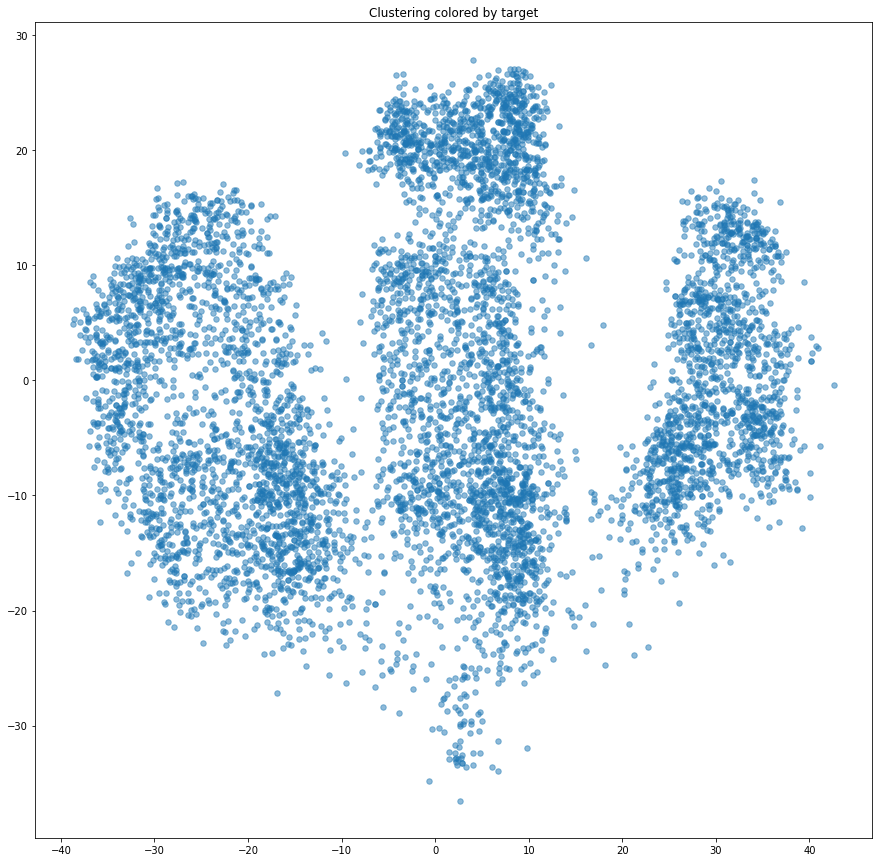

In [7]:
fig, axes = plt.subplots(1, 1, figsize=(15, 15))
sc = axes.scatter(GPT1(alldata), GPT2(alldata), alpha=.5, s=30)
_ = axes.set_title("Clustering colored by target")

In [23]:
cluster = pd.DataFrame(y_tr,columns=['target'])
cluster['target'] = y_tr.values
cluster['target'] = pd.cut(cluster['target'],10,labels=False)

In [25]:
del fig

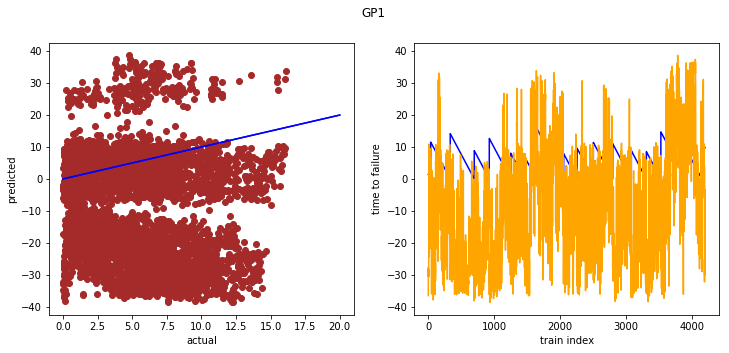

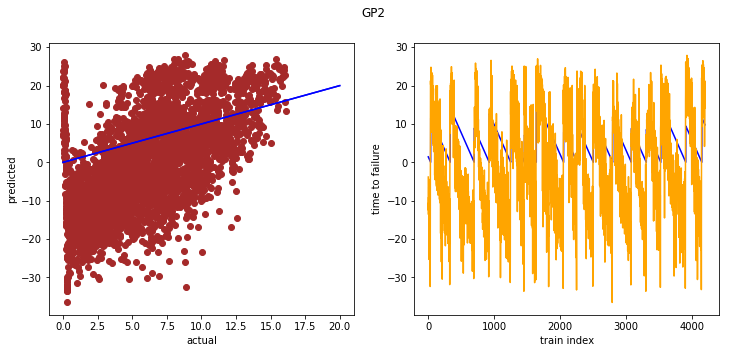

In [33]:
fig, axis = plt.subplots(1, 2, figsize=(12,5))
plt.suptitle('GP1')
ax1, ax2 = axis
ax1.set_xlabel('actual')
ax1.set_ylabel('predicted')
ax2.set_xlabel('train index')
ax2.set_ylabel('time to failure')
ax1.scatter(y_tr, GPT1(alldata[:len(y_tr)]), color='brown')
ax1.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)], color='blue')
ax2.plot(y_tr, color='blue', label='y_train')
ax2.plot(GPT1(alldata[:len(y_tr)]), color='orange')

fig, axis = plt.subplots(1, 2, figsize=(12,5))
plt.suptitle('GP2')
ax1, ax2 = axis
ax1.set_xlabel('actual')
ax1.set_ylabel('predicted')
ax2.set_xlabel('train index')
ax2.set_ylabel('time to failure')
ax1.scatter(y_tr, GPT2(alldata[:len(y_tr)]), color='brown')
ax1.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)], color='blue')

ax2.plot(y_tr, color='blue', label='y_train')
ax2.plot(GPT2(alldata[:len(y_tr)]), color='orange')

SyntaxError: invalid syntax (<ipython-input-10-4e2b9586ccc3>, line 9)

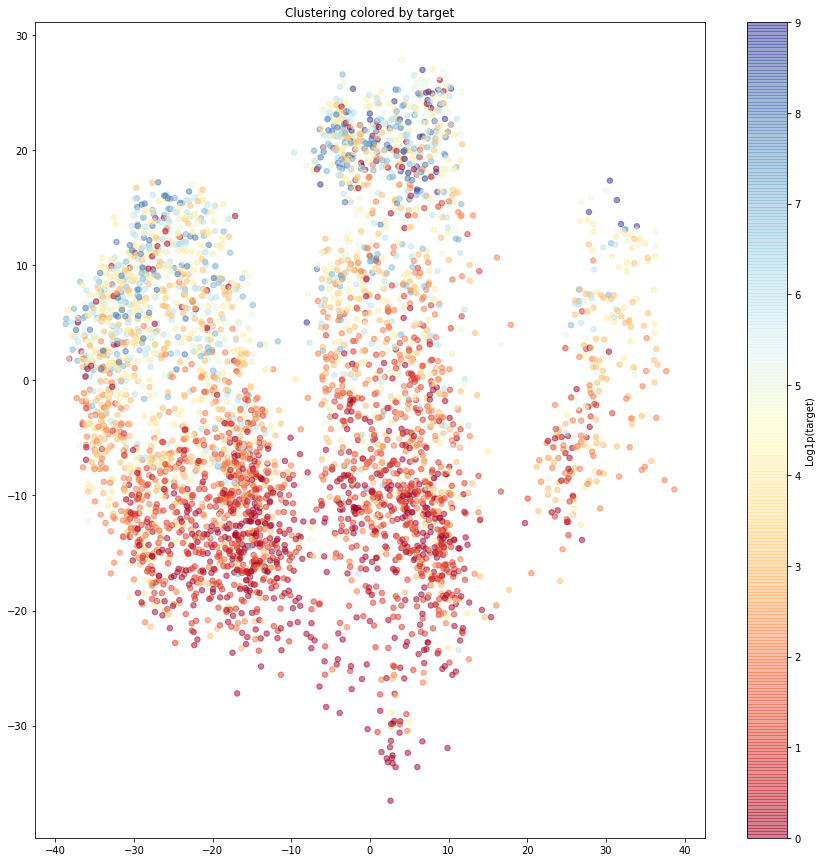

In [9]:
cm = plt.cm.get_cmap('RdYlBu')
fig, axes = plt.subplots(1, 1, figsize=(15, 15))
sc = axes.scatter(GPT1(alldata[:len(y_tr)]), GPT2(alldata[:len(y_tr)]), alpha=.5, c=cluster.target, cmap=cm, s=30)
cbar = fig.colorbar(sc, ax=axes)
cbar.set_label('Log1p(target)')
_ = axes.set_title("Clustering colored by target")

Anyone else seen 3 distinct channels using a Kullback-Leibler Divergence Cluster?  Looks a bit like a maple leaf!